In [1]:
from import_library import * 
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text  
from nltk.stem.snowball import SnowballStemmer # stemmes words

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator# creates words colud
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFECV 


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tld import get_tld, is_tld
from urllib.parse import urlparse
import re
import ipaddress
import re
import string
import logging

# from colorama import Fore
from plotly.subplots import make_subplots
from plotly import graph_objects as go
# from gensim.models import Word2Vec
import tldextract
import hashlib
# import whois

import pickle

# Parameters

In [2]:
data_path = 'data/'
save_path = 'results_method_2/'
file = 'dataset.csv'

# Function

In [3]:
def read_file_csv(file):
    '''   
    Read csv file 
    ----------
    Attributes:
    file: file
    ----------
    Example:
    file = 'dataset.csv'
    data = read_file_csv(file)
    '''
    data = pd.read_csv(data_path + file, sep=',',header = 0)
    # data['Change %'] = data['Change %'].apply(convert_percentage_object_2_float)    
    return data

def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    '''    
    Word Cloud plot
    ----------
    Attributes:
    text: input data 
    ----------     
    Example:
    common_text = str(data_good)
    plot_wordcloud(common_text, max_words=100, max_font_size=50, 
               title = 'Most common words use in legitimate urls', title_size=20)
    '''   
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    #mask = mask
                         )
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

### Explanatory Data Analysis
def univariate_analysis(data,features):
    '''    
    Plot Univariate distribution plot
    ----------
    Attributes:
    data : pd.DataFrame                
    features: list
        list of features of the df_dataset
    save: bool, default: False
        save or not
    ----------
    Example:
    univariate_analysis(data,features)
    '''    
    n_cols = 4
    n_rows = int(math.ceil(len(features)/n_cols))    
    fig,axes = plt.subplots(nrows=n_rows , ncols= n_cols,figsize = (22,12))
    for idx, feature in enumerate(features):
        row,col = idx//n_cols, idx%n_cols 
        sns.distplot(data[feature], ax = axes[row][col])        
    
def each_class_distribution_analyis(data,features, box=1, outlier = True):
    '''    
    Plot each class distribution plot (violin or boxplot)
    ----------
    Attributes:
    data : pd.DataFrame                
    features: list
        list of features of the df_dataset
    box: int, default: 1
    outlier: bool, default: True
        including outlier or not 
    save: bool, default: False
        save or not
    ----------
    Example:
    univariate_analysis(data,features)
    '''    
    n_cols = 4
    n_rows = int(math.ceil(len(features)/n_cols))    
    fig,axes = plt.subplots(nrows=n_rows , ncols= n_cols,figsize = (22,12))
    for idx, feature in enumerate(features):
        row,col = idx//n_cols, idx%n_cols 
        if box == 1:
            sns.boxplot(x='quality',y = feature ,data=data,ax = axes[row][col],showfliers = outlier )
        else:
            sns.violinplot(x='quality',y = feature ,data=data,ax = axes[row][col] )

def univariate_boxplot_analysis(data,features,outlier = True):
    '''    
    Box plot of each features
    ----------
    Attributes:
    data : pd.DataFrame                
    features: list
        list of features of the df_dataset
    outlier: bool, default: True
        including outlier or not 
    save: bool, default: False
        save or not
    ----------
    Example:
    univariate_analysis(data,features)
    '''
    n_cols = 4
    n_rows = int(math.ceil(len(features)/n_cols))    
    fig,axes = plt.subplots(nrows=n_rows , ncols= n_cols,figsize = (22,12))
    for idx, feature in enumerate(features):
        row,col = idx//n_cols, idx%n_cols 
        sns.boxplot(data[feature], ax = axes[row][col],showfliers=outlier)        
    plt.show()

def outlier_removal(data,features):
    '''
    Remove outlier of each feature
    ----------
    Attributes:
    data : pd.DataFrame                
    features: list
        list of features of the df_dataset
    outlier: bool, default: True
        including outlier or not 
    save: bool, default: False
        save or not
    ----------
    Results:
    filtered_df: pd.DataFrame
    df_outlier: pd.DataFrame
    ----------
    Example:
    univariate_analysis(data,features)
    '''
    df_outlier = pd.DataFrame()
    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        outlier_range = Q1-1.5*IQR , Q3+1.5*IQR
        cond = (data[feature] < outlier_range[0]) | (data[feature] > outlier_range[1])
        outliers = data[cond]
        df_outlier = pd.concat([df_outlier, outliers])
    df_outlier.drop_duplicates(inplace=True)
    
    filtered_df = data.drop(data_outlier.index.to_list())
    filtered_df.reset_index(drop=True,inplace=True)
    return filtered_df,df_outlier

### Model 
def model_fitting(model,trainX,trainY,testX,testY):
    '''
    Model Fitting 
    ----------
    Attributes:
    model : machine learning framework
    trainX,trainY,testX,testY: input data
    ----------
    Return:
    model.score: Accuracy on the Test Set
    model : machine learning framework
    ----------    
    Example:
    lr = LogisticRegression()# before fitting
    lr, lr_score = model_fitting(lr, trainX, trainY, testX, testY)
    '''
    model.fit(trainX,trainY)    
    
    return model,model.score(testX,testY)

def model_evalution_report(model, trainX, trainY, testX, testY):
    '''    
    Model Evaluation Report
    ----------
    Attributes:
    model : machine learning framework
    trainX,trainY,testX,testY: input data
    ----------
    Example:
    model_evalution_report(lr, trainX, trainY, testX, testY)
    '''   
    print(f'Training Accuracy : {model.score(trainX,trainY):.3f}',)
    print(f'Testing Accuracy : {model.score(testX,testY):.3f}',)
    con_mat = pd.DataFrame(confusion_matrix(testY, model.predict(testX) ),
                columns = ['Predicted:0', 'Predicted:1'],
                index = ['Actual:0', 'Actual:1'])
    
    
    print('\nCLASSIFICATION REPORT\n')
    print(classification_report(testY, model.predict(testX),
                                target_names =['0','1']))
    
    print('\nCONFUSION MATRIX')
    plt.figure(figsize= (6,4))
    sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")
    

def model_evaluation_score(model, trainX, trainY, testX, testY):
    '''    
    Model evaluation score
    ----------
    Attributes:
    model : machine learning framework
    trainX,trainY,testX,testY: input data
    ----------  
    Results:
    Accuracy, F1-score, recall, precision, specificity on the test set
    ----------  
    Example:
    model = 'Logistic Regression'
    acc_test,f1_score_test,recall_score_test,precision_score_test,specificity_score_test = model_evaluation_score(lr, trainX, trainY, testX, testY)
    '''   
    predict_trainX = model.predict(trainX)
    predict_testX = model.predict(testX)
    
    
    acc_train = metrics.accuracy_score(trainY,predict_trainX)
    acc_test = metrics.accuracy_score(testY,predict_testX)
    
    f1_score_train = metrics.f1_score(trainY,predict_trainX)
    f1_score_test = metrics.f1_score(testY,predict_testX)
        
    tp, fn, fp, tn = confusion_matrix(testY, predict_testX).ravel()         
    specificity_score_test = tn / (tn+fp)
    precision_score_test = tp/ (tp+fp)
    recall_score_test = tp/(tp+fn)
    
    return acc_test,f1_score_test,recall_score_test,precision_score_test, specificity_score_test

def save_model(model,save_path,title):
    '''    
    Save Model
    ----------
    Attributes:
    model : model from ML
    save_path: saving repository
    title: str  
    ----------     
    Example:
    title = 'RFR_8field_Tuned_model.sav'
    save_model(model,save_path,title)
    '''    
    if not os.path.exists(f'{save_path}/model'):
        os.makedirs( f'{save_path}/model')
    file_name = f'{save_path}/model/{title}'
    with open(file_name, 'wb') as f:
        pickle.dump(model,f)    
        
def load_model(save_path,title):
    '''    
    Load Model
    ----------
    Attributes:
    save_path: loading repository
    title: str  
    ----------     
    Example:
    title = 'RFR_8field_Tuned_model.sav'
    loaded_model = load_model(save_path,title)
    '''    
    file_name = f'{save_path}/model/{title}'
    with open(file_name,'rb') as f:
        model = pickle.load(f)
    return model

def correlation_matrix(data,title=None,save=False):
    '''    
    Plot Correlation Matrix
    ----------
    Attributes:
    df_smoothed_scaled_filterd_dataset : pd.DataFrame                
    orderedFeatured: list
        list of features of the df_dataset
    title: str, default: None
        The name of saved file
    save: bool, default: False
        save or not
    ----------
    Example:
    CorrelationMatrix(df_smoothed_scaled_filterd_dataset,orderedFeatured,title=None,save=False)
    '''    
    plt.close('all')
    train = data
    plt.figure(figsize=(15, 15))
    dataplot = sns.heatmap(train.corr(), xticklabels=train.corr().columns, yticklabels=train.corr().columns,  cmap="YlGnBu", annot=True)
    if title == None:
        title = 'corr.png'    
    if save:
        if not os.path.exists(f'{save_path}/'):
            os.makedirs( f'{save_path}/')  
        plt.savefig(f'{save_path}/{title}', bbox_inches="tight")    
    plt.show()


# Data Injection

In [4]:
data = read_file_csv(file)

In [5]:
data 
# data type object and float 

,domain,label
0,http://sprint.com/business/solutions/mobility_...,0.000
1,hesperia.gsfc.nasa.gov/~schmahl/nnls/,0.000
2,http://web.de/magazine/digital/sicher-im-netz/...,0.000
3,www.wired.com/science/discoveries/news/1999/08...,0.000
4,thomas.arnatt.com/wp-includes/pono/AOL_Logio.htm,1.000
...,...,...
120985,http://emgn.com/tv/watch-just-be-glad-these-di...,0.000
120986,www.minisoftindia.com/entourage,0.000
120987,https://medium.com/@VPOTUS/the-vice-president-...,0.000
120988,libguides.com,0.000


In [6]:
data.isnull().sum()

domain    0
label     0
dtype: int64

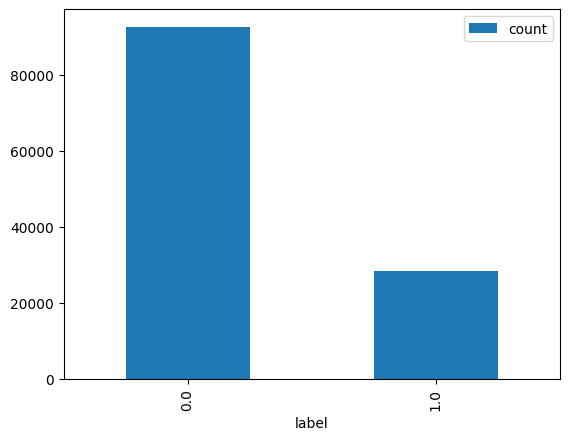

In [7]:
#create a dataframe of classes counts
label_counts = pd.DataFrame(data['label'].value_counts())
# #visualizing target_col
fig = label_counts.plot.bar()

In [55]:
label_counts

,count
label,
0.000,92680
1.000,28310


Dataset Comment:
- Data is containg 120,990 unique entries.
- There are two columns (domain and label)
- Label column is prediction col which has 2 categories 
    + 0 - which means the urls is not containing malicious stuff and this site is not a Phishing Site - 76.6%
    + 1 - which means the urls contains malicious stuffs and this site is a Phishing Site -  23,4% 
--> Imbalancing Data 
- There is no missing value in the dataset.

# Visualization
1. Visualize some important keys using word cloud

In [67]:
#sliceing classes
bad_sites = data[data.label == 1 ]
good_sites = data[data.label == 0 ]

In [114]:
data_good = good_sites.text_sent
data_good.reset_index(drop=True, inplace=True)

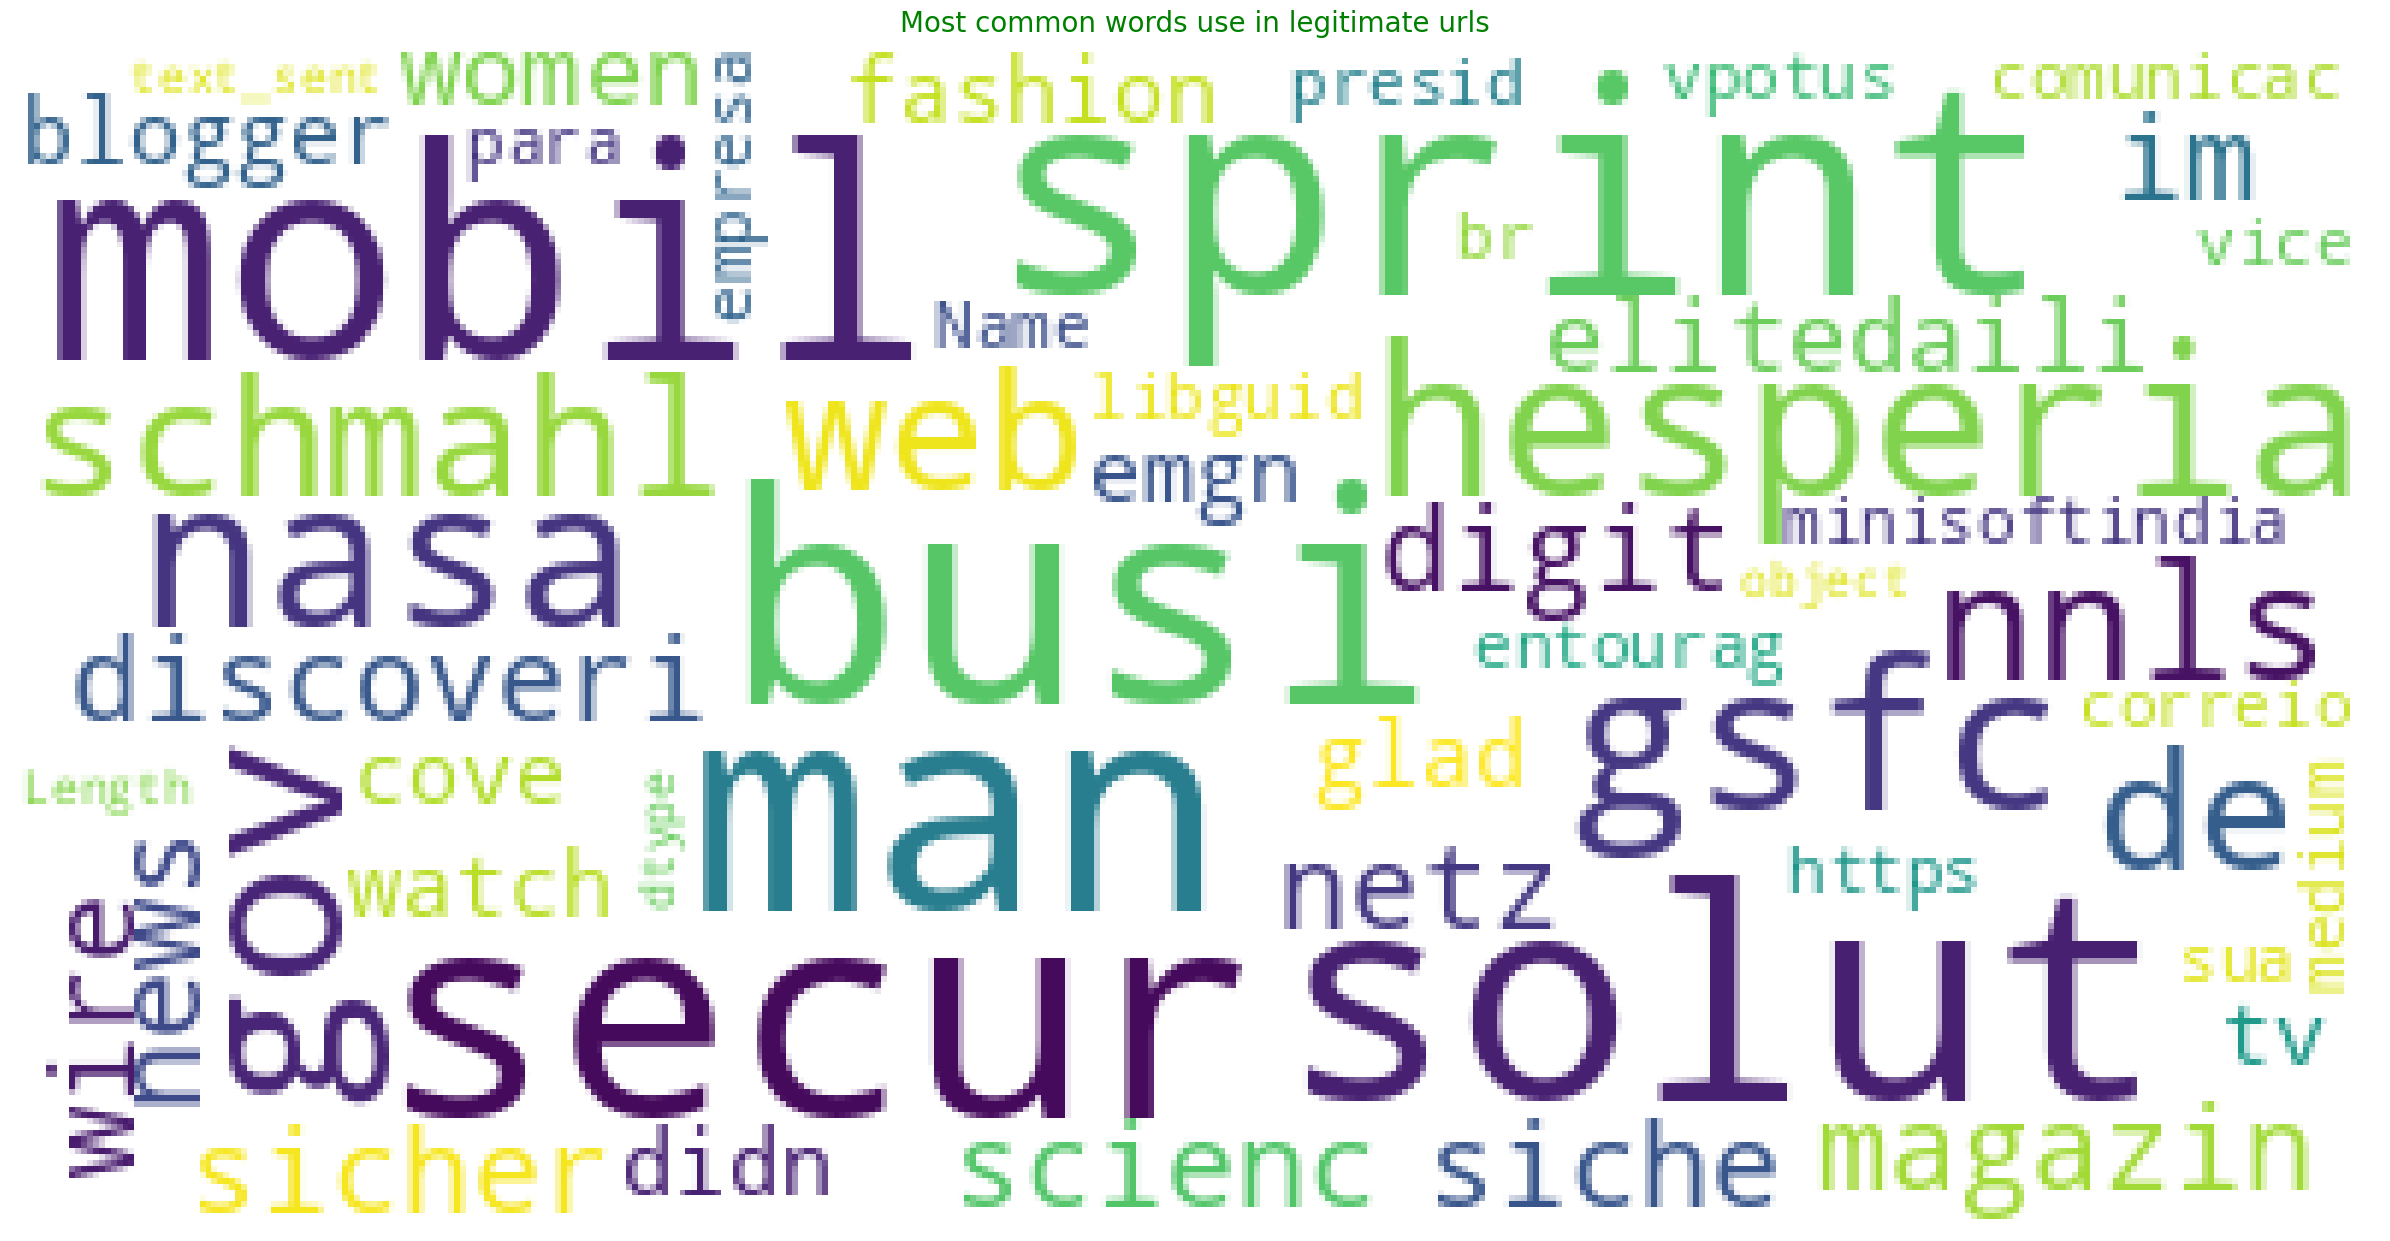

In [159]:
common_text = str(data_good)
plot_wordcloud(common_text, max_words=100, max_font_size=50, 
               title = 'Most common words use in legitimate urls', title_size=20)

In [117]:
data_bad = bad_sites.text_sent
data_bad.reset_index(drop=True, inplace=True)

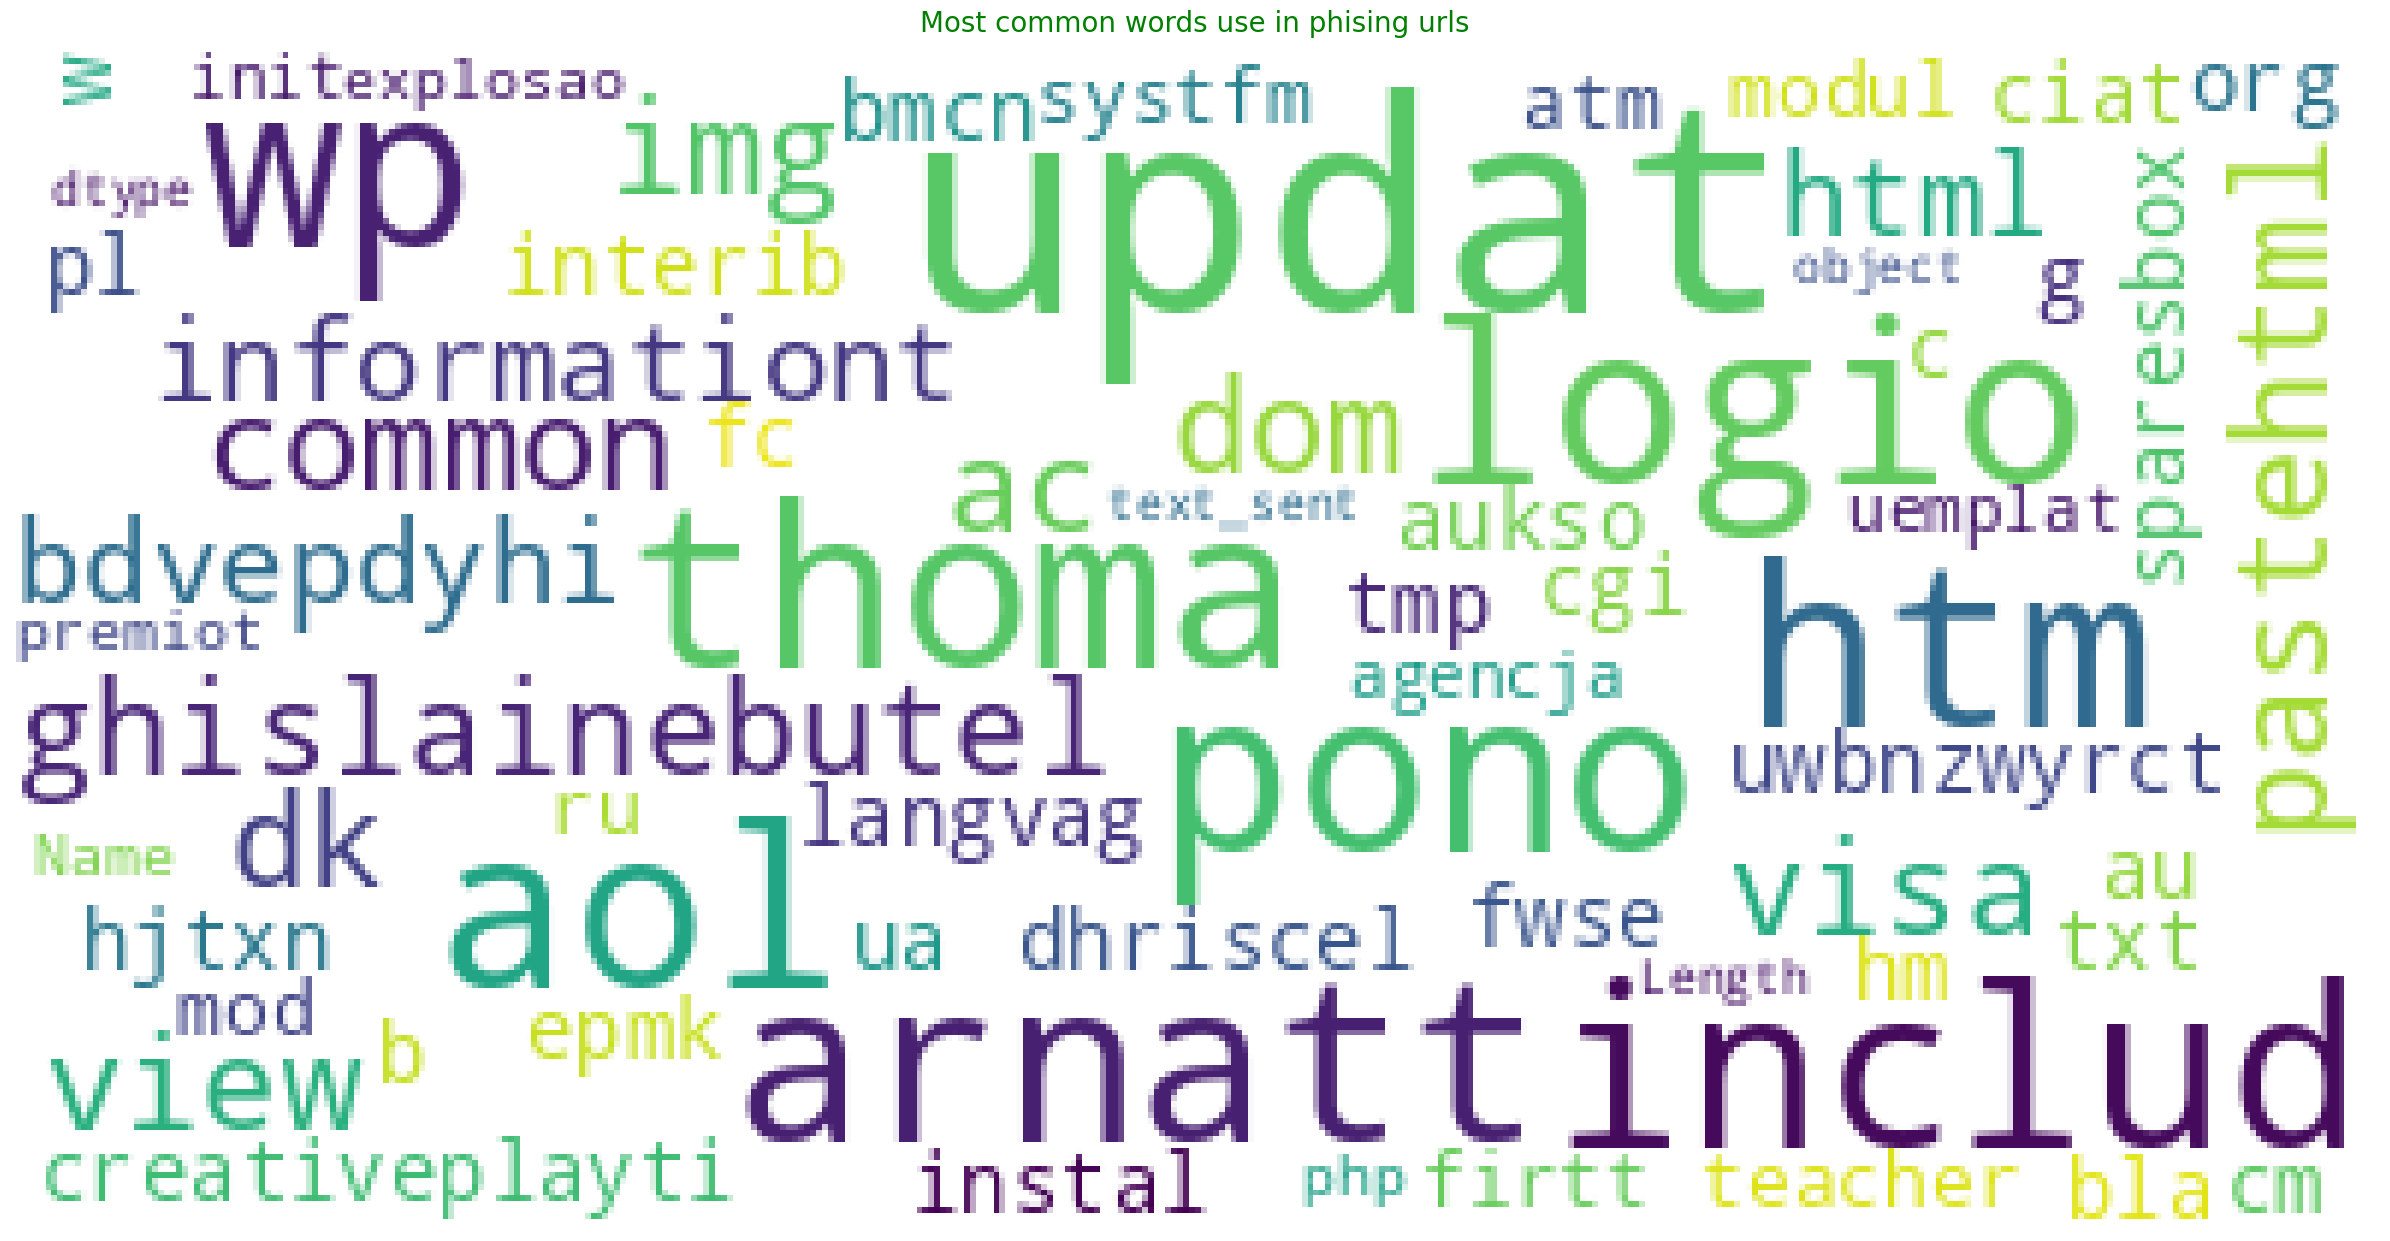

In [157]:
common_text = str(data_bad)
plot_wordcloud(common_text, max_words=100, max_font_size=50, 
               title = 'Most common words use in phising urls', title_size=20)

# Feature Enginnering (Extraction)

Extract feature from domains(urls) refered from the paper "Sophisticated_Framework_for_the_Accurate_Detection_of_Phising_Websites" table 2:

- Get url lengh 
- Extract primary domain
- Check whether domains having https (secure)
- Count the number of digit characters
- Count the number of letter characters
- Count special characters
- Check whether domains containing a shortening service
- Check wether having abnormal domain
- Check wether having IP address
- Extract regional domain
- Extract root domain

In [9]:
def get_url_length(url):
    # Remove common prefixes
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        if url.startswith(prefix):
            url = url[len(prefix):]
    
    # Remove 'www.' if present
    url = url.replace('www.', '')
    
    # Return the length of the remaining URL
    return len(url)

data['domain_len'] = data['domain'].apply(lambda x: get_url_length(str(x)))

In [10]:
data['domain_len'].value_counts()

domain_len
27     4434
33     2879
26     2719
28     2073
30     2068
       ... 
398       1
510       1
371       1
423       1
370       1
Name: count, Length: 451, dtype: int64

In [11]:
def plot_hist(data,bins=50):
    '''
    plot histogram
    Ex: 
    plot_hist(data['domain_len'],80)
    '''
    _ = plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
    plt.ylabel('Frequency')
    plt.xlabel('Len')
    plt.grid()

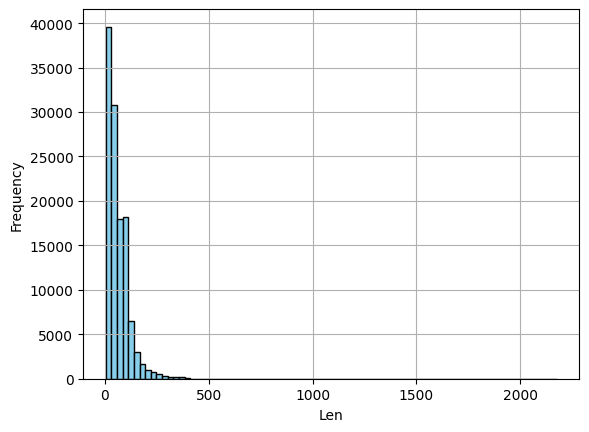

In [12]:
plot_hist(data['domain_len'],80)

Domain length distribution follows expotional distribution with high frequency at the beginning and lower to the rest of disribution

In [13]:
def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

data['pri_domain'] = data['domain'].apply(lambda i: extract_pri_domain(i))

In [14]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

data['https'] = data['domain'].apply(lambda i: httpSecure(i))
data['https'].value_counts()

https
0    119040
1      1950
Name: count, dtype: int64

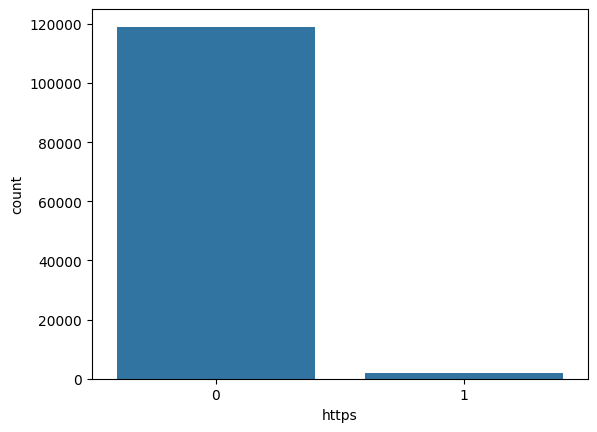

In [15]:
sns.countplot(x='https', data=data);

In [16]:
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits

def count_special_chars(url):
    special_chars = set(string.punctuation)
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars

In [17]:
data['letters_count']        = data['domain'].apply(lambda x: count_letters(x))
data['digits_count']         = data['domain'].apply(lambda x: count_digits(x))
data['special_chars_count']  = data['domain'].apply(lambda x: count_special_chars(x))

Text(0.5, 1.0, 'The sum of all letters, digits and special characters count ')

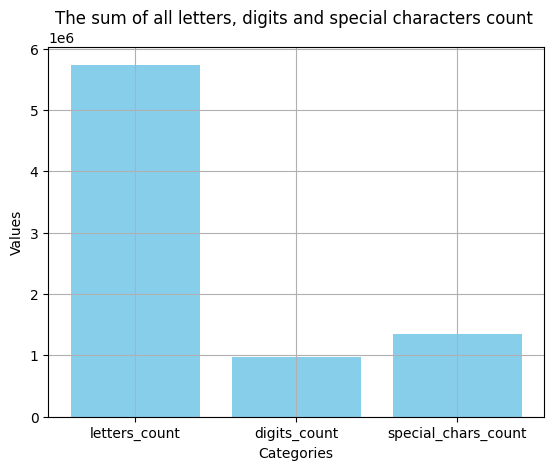

In [18]:
# Sample data
categories = ['letters_count', 'digits_count', 'special_chars_count',]
values = [data['letters_count'].sum(), data['digits_count'].sum(), data['special_chars_count'].sum()]

# Plotting the bar plot
_ = plt.bar(categories, values, color='skyblue')

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.grid()
plt.title('The sum of all letters, digits and special characters count ')

In [19]:
data['digits_count'].sum()

977829

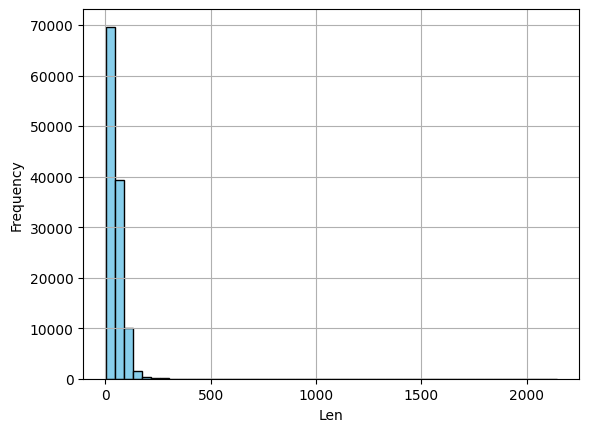

In [20]:
plot_hist(data['letters_count'],bins=50)

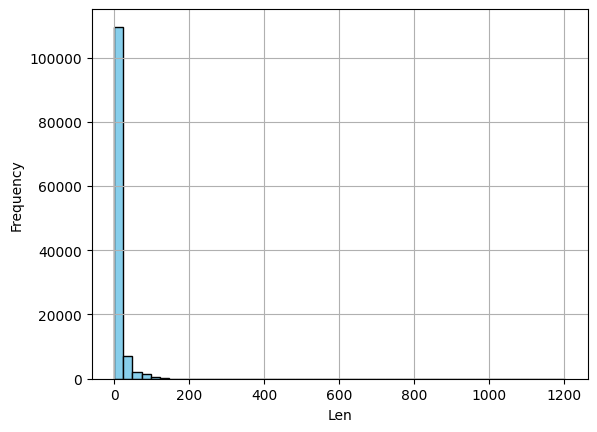

In [21]:
plot_hist(data['digits_count'],bins=50)

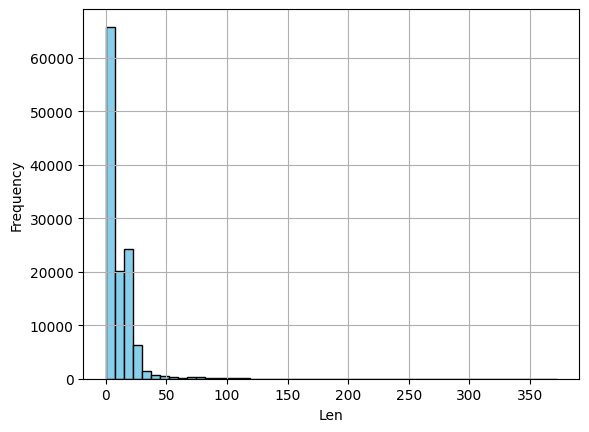

In [22]:
plot_hist(data['special_chars_count'],bins=50)

In [23]:
def has_shortening_service(url):
    pattern = re.compile(r'https?://(?:www\.)?(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)
    
    if match:
        domain = match.group(1)
        common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
                                      'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
                                      'su', 'snipurl', 'short', 'BudURL', 'ping', 
                                      'post', 'Just', 'bkite', 'snipr', 'fic', 
                                      'loopt', 'doiop', 'short', 'kl', 'wp', 
                                      'rubyurl', 'om', 'to', 'bit', 't', 'lnkd', 
                                      'db', 'qr', 'adf', 'goo', 'bitly', 'cur', 
                                      'tinyurl', 'ow', 'bit', 'ity', 'q', 'is', 
                                      'po', 'bc', 'twitthis', 'u', 'j', 'buzurl', 
                                      'cutt', 'u', 'yourls', 'x', 'prettylinkpro', 
                                      'scrnch', 'filoops', 'vzturl', 'qr', '1url', 
                                      'tweez', 'v', 'tr', 'link', 'zip']
        
        if domain.lower() in common_shortening_services:
            return 1
    return 0

data['Shortining_Service']  = data['domain'].apply(lambda x: has_shortening_service(x))
data['Shortining_Service'].value_counts() # --> no need, either -> all

Shortining_Service
0    120990
Name: count, dtype: int64

In [24]:
def abnormal_url(url):
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc
    if netloc:
        netloc = str(netloc)
        match = re.search(netloc, url)
        if match:
            return 1
    return 0

data['abnormal_domain']  = data['domain'].apply(lambda x: abnormal_url(x))
data['abnormal_domain'].value_counts()

abnormal_domain
0    85612
1    35378
Name: count, dtype: int64

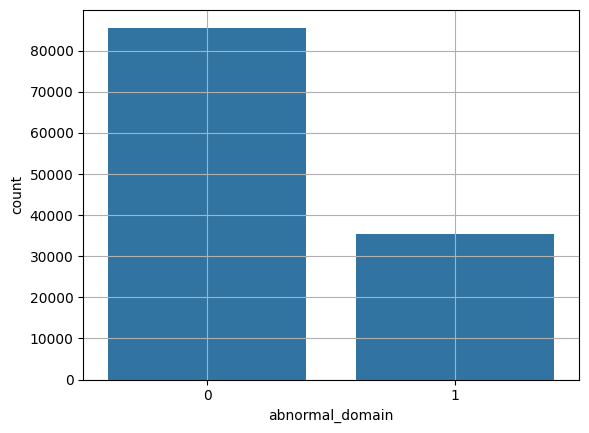

In [25]:
sns.countplot(x='abnormal_domain', data=data)
plt.grid()

In [26]:
def have_ip_address(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            ip = ipaddress.ip_address(parsed_url.hostname)
            return isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address))
    except ValueError:
        pass  # Invalid hostname or IP address

    return 0

data['have_ip']  = data['domain'].apply(lambda x: have_ip_address(x))
data['have_ip'].value_counts()
# having ip --> all

have_ip
0    120990
Name: count, dtype: int64

In [27]:
data.isnull().sum()
# Handing the pri_domain missing values

domain                    0
label                     0
domain_len                0
pri_domain             3619
https                     0
letters_count             0
digits_count              0
special_chars_count       0
Shortining_Service        0
abnormal_domain           0
have_ip                   0
dtype: int64

In [28]:
data.fillna(0,inplace=True)

In [29]:
data.isnull().sum()

domain                 0
label                  0
domain_len             0
pri_domain             0
https                  0
letters_count          0
digits_count           0
special_chars_count    0
Shortining_Service     0
abnormal_domain        0
have_ip                0
dtype: int64

In [30]:
def get_url_region(primary_domain):
    ccTLD_to_region = {
    ".ac": "Ascension Island",
    ".ad": "Andorra",
    ".ae": "United Arab Emirates",
    ".af": "Afghanistan",
    ".ag": "Antigua and Barbuda",
    ".ai": "Anguilla",
    ".al": "Albania",
    ".am": "Armenia",
    ".an": "Netherlands Antilles",
    ".ao": "Angola",
    ".aq": "Antarctica",
    ".ar": "Argentina",
    ".as": "American Samoa",
    ".at": "Austria",
    ".au": "Australia",
    ".aw": "Aruba",
    ".ax": "Åland Islands",
    ".az": "Azerbaijan",
    ".ba": "Bosnia and Herzegovina",
    ".bb": "Barbados",
    ".bd": "Bangladesh",
    ".be": "Belgium",
    ".bf": "Burkina Faso",
    ".bg": "Bulgaria",
    ".bh": "Bahrain",
    ".bi": "Burundi",
    ".bj": "Benin",
    ".bm": "Bermuda",
    ".bn": "Brunei Darussalam",
    ".bo": "Bolivia",
    ".br": "Brazil",
    ".bs": "Bahamas",
    ".bt": "Bhutan",
    ".bv": "Bouvet Island",
    ".bw": "Botswana",
    ".by": "Belarus",
    ".bz": "Belize",
    ".ca": "Canada",
    ".cc": "Cocos Islands",
    ".cd": "Democratic Republic of the Congo",
    ".cf": "Central African Republic",
    ".cg": "Republic of the Congo",
    ".ch": "Switzerland",
    ".ci": "Côte d'Ivoire",
    ".ck": "Cook Islands",
    ".cl": "Chile",
    ".cm": "Cameroon",
    ".cn": "China",
    ".co": "Colombia",
    ".cr": "Costa Rica",
    ".cu": "Cuba",
    ".cv": "Cape Verde",
    ".cw": "Curaçao",
    ".cx": "Christmas Island",
    ".cy": "Cyprus",
    ".cz": "Czech Republic",
    ".de": "Germany",
    ".dj": "Djibouti",
    ".dk": "Denmark",
    ".dm": "Dominica",
    ".do": "Dominican Republic",
    ".dz": "Algeria",
    ".ec": "Ecuador",
    ".ee": "Estonia",
    ".eg": "Egypt",
    ".er": "Eritrea",
    ".es": "Spain",
    ".et": "Ethiopia",
    ".eu": "European Union",
    ".fi": "Finland",
    ".fj": "Fiji",
    ".fk": "Falkland Islands",
    ".fm": "Federated States of Micronesia",
    ".fo": "Faroe Islands",
    ".fr": "France",
    ".ga": "Gabon",
    ".gb": "United Kingdom",
    ".gd": "Grenada",
    ".ge": "Georgia",
    ".gf": "French Guiana",
    ".gg": "Guernsey",
    ".gh": "Ghana",
    ".gi": "Gibraltar",
    ".gl": "Greenland",
    ".gm": "Gambia",
    ".gn": "Guinea",
    ".gp": "Guadeloupe",
    ".gq": "Equatorial Guinea",
    ".gr": "Greece",
    ".gs": "South Georgia and the South Sandwich Islands",
    ".gt": "Guatemala",
    ".gu": "Guam",
    ".gw": "Guinea-Bissau",
    ".gy": "Guyana",
    ".hk": "Hong Kong",
    ".hm": "Heard Island and McDonald Islands",
    ".hn": "Honduras",
    ".hr": "Croatia",
    ".ht": "Haiti",
    ".hu": "Hungary",
    ".id": "Indonesia",
    ".ie": "Ireland",
    ".il": "Israel",
    ".im": "Isle of Man",
    ".in": "India",
    ".io": "British Indian Ocean Territory",
    ".iq": "Iraq",
    ".ir": "Iran",
    ".is": "Iceland",
    ".it": "Italy",
    ".je": "Jersey",
    ".jm": "Jamaica",
    ".jo": "Jordan",
    ".jp": "Japan",
    ".ke": "Kenya",
    ".kg": "Kyrgyzstan",
    ".kh": "Cambodia",
    ".ki": "Kiribati",
    ".km": "Comoros",
    ".kn": "Saint Kitts and Nevis",
    ".kp": "Democratic People's Republic of Korea (North Korea)",
    ".kr": "Republic of Korea (South Korea)",
    ".kw": "Kuwait",
    ".ky": "Cayman Islands",
    ".kz": "Kazakhstan",
    ".la": "Laos",
    ".lb": "Lebanon",
    ".lc": "Saint Lucia",
    ".li": "Liechtenstein",
    ".lk": "Sri Lanka",
    ".lr": "Liberia",
    ".ls": "Lesotho",
    ".lt": "Lithuania",
    ".lu": "Luxembourg",
    ".lv": "Latvia",
    ".ly": "Libya",
    ".ma": "Morocco",
    ".mc": "Monaco",
    ".md": "Moldova",
    ".me": "Montenegro",
    ".mf": "Saint Martin (French part)",
    ".mg": "Madagascar",
    ".mh": "Marshall Islands",
    ".mk": "North Macedonia",
    ".ml": "Mali",
    ".mm": "Myanmar",
    ".mn": "Mongolia",
    ".mo": "Macao",
    ".mp": "Northern Mariana Islands",
    ".mq": "Martinique",
    ".mr": "Mauritania",
    ".ms": "Montserrat",
    ".mt": "Malta",
    ".mu": "Mauritius",
    ".mv": "Maldives",
    ".mw": "Malawi",
    ".mx": "Mexico",
    ".my": "Malaysia",
    ".mz": "Mozambique",
    ".na": "Namibia",
    ".nc": "New Caledonia",
    ".ne": "Niger",
    ".nf": "Norfolk Island",
    ".ng": "Nigeria",
    ".ni": "Nicaragua",
    ".nl": "Netherlands",
    ".no": "Norway",
    ".np": "Nepal",
    ".nr": "Nauru",
    ".nu": "Niue",
    ".nz": "New Zealand",
    ".om": "Oman",
    ".pa": "Panama",
    ".pe": "Peru",
    ".pf": "French Polynesia",
    ".pg": "Papua New Guinea",
    ".ph": "Philippines",
    ".pk": "Pakistan",
    ".pl": "Poland",
    ".pm": "Saint Pierre and Miquelon",
    ".pn": "Pitcairn",
    ".pr": "Puerto Rico",
    ".ps": "Palestinian Territory",
    ".pt": "Portugal",
    ".pw": "Palau",
    ".py": "Paraguay",
    ".qa": "Qatar",
    ".re": "Réunion",
    ".ro": "Romania",
    ".rs": "Serbia",
    ".ru": "Russia",
    ".rw": "Rwanda",
    ".sa": "Saudi Arabia",
    ".sb": "Solomon Islands",
    ".sc": "Seychelles",
    ".sd": "Sudan",
    ".se": "Sweden",
    ".sg": "Singapore",
    ".sh": "Saint Helena",
    ".si": "Slovenia",
    ".sj": "Svalbard and Jan Mayen",
    ".sk": "Slovakia",
    ".sl": "Sierra Leone",
    ".sm": "San Marino",
    ".sn": "Senegal",
    ".so": "Somalia",
    ".sr": "Suriname",
    ".ss": "South Sudan",
    ".st": "São Tomé and Príncipe",
    ".sv": "El Salvador",
    ".sx": "Sint Maarten (Dutch part)",
    ".sy": "Syria",
    ".sz": "Eswatini",
    ".tc": "Turks and Caicos Islands",
    ".td": "Chad",
    ".tf": "French Southern Territories",
    ".tg": "Togo",
    ".th": "Thailand",
    ".tj": "Tajikistan",
    ".tk": "Tokelau",
    ".tl": "Timor-Leste",
    ".tm": "Turkmenistan",
    ".tn": "Tunisia",
    ".to": "Tonga",
    ".tr": "Turkey",
    ".tt": "Trinidad and Tobago",
    ".tv": "Tuvalu",
    ".tw": "Taiwan",
    ".tz": "Tanzania",
    ".ua": "Ukraine",
    ".ug": "Uganda",
    ".uk": "United Kingdom",
    ".us": "United States",
    ".uy": "Uruguay",
    ".uz": "Uzbekistan",
    ".va": "Vatican City",
    ".vc": "Saint Vincent and the Grenadines",
    ".ve": "Venezuela",
    ".vg": "British Virgin Islands",
    ".vi": "U.S. Virgin Islands",
    ".vn": "Vietnam",
    ".vu": "Vanuatu",
    ".wf": "Wallis and Futuna",
    ".ws": "Samoa",
    ".ye": "Yemen",
    ".yt": "Mayotte",
    ".za": "South Africa",
    ".zm": "Zambia",
    ".zw": "Zimbabwe"
    }
    
    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]
    
    return "Global"

data['domain_region'] = data['pri_domain'].apply(lambda x: get_url_region(str(x)))
data.domain_region.value_counts()

domain_region
Global                   90517
United Kingdom            3088
Germany                   1953
Vietnam                   1751
Russia                    1668
                         ...  
Niger                        1
Faroe Islands                1
Republic of the Congo        1
Cayman Islands               1
Bouvet Island                1
Name: count, Length: 203, dtype: int64

In [31]:
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain
data['root_domain'] = data['pri_domain'].apply(lambda x: extract_root_domain(str(x)))
data.root_domain.value_counts()

root_domain
0                3619
ietf             3212
torcache         1368
olx              1333
angelfire        1307
                 ... 
sbilyb              1
weinmanntours       1
isleofavalon        1
fjoreg              1
libguides           1
Name: count, Length: 40904, dtype: int64

In [32]:
# hash encode converting
def hash_encode(category):
    hash_object = hashlib.md5(category.encode())
    return int(hash_object.hexdigest(), 16) % (10 ** 8)
data['root_domain'] = data['root_domain'].apply(hash_encode)
data['domain_region'] = data['domain_region'].apply(hash_encode)

In [33]:
data

,domain,label,domain_len,pri_domain,https,letters_count,digits_count,special_chars_count,Shortining_Service,abnormal_domain,have_ip,domain_region,root_domain
0,http://sprint.com/business/solutions/mobility_...,0.000,98,sprint.com,0,89,0,16,0,1,0,32604616,75249601
1,hesperia.gsfc.nasa.gov/~schmahl/nnls/,0.000,37,hesperia.gsfc.nasa.gov,0,30,0,7,0,0,0,32604616,93550625
2,http://web.de/magazine/digital/sicher-im-netz/...,0.000,124,web.de,0,105,8,18,0,1,0,96149071,60093853
3,www.wired.com/science/discoveries/news/1999/08...,0.000,48,www.wired.com,0,33,11,8,0,0,0,32604616,27017123
4,thomas.arnatt.com/wp-includes/pono/AOL_Logio.htm,1.000,48,thomas.arnatt.com,0,40,0,8,0,0,0,32604616,67272100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120985,http://emgn.com/tv/watch-just-be-glad-these-di...,0.000,89,emgn.com,0,74,0,22,0,1,0,32604616,60846164
120986,www.minisoftindia.com/entourage,0.000,27,www.minisoftindia.com,0,28,0,3,0,0,0,32604616,83573928
120987,https://medium.com/@VPOTUS/the-vice-president-...,0.000,154,medium.com,1,125,10,27,0,1,0,32604616,51702035
120988,libguides.com,0.000,13,libguides.com,0,12,0,1,0,0,0,32604616,67181888


In [85]:
# df = data.drop(columns=['domain','label','pri_domain','have_ip','Shortining_Service'])
df = data.drop(columns=['domain','label','pri_domain'])

# Explanatory Data Analyis

In [103]:
features = df.columns.to_list()
features

['domain_len',
 'https',
 'letters_count',
 'digits_count',
 'special_chars_count',
 'Shortining_Service',
 'abnormal_domain',
 'have_ip',
 'domain_region',
 'root_domain']

In [36]:
df.shape

(120990, 8)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120990 entries, 0 to 120989
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   domain_len           120990 non-null  int64
 1   https                120990 non-null  int64
 2   letters_count        120990 non-null  int64
 3   digits_count         120990 non-null  int64
 4   special_chars_count  120990 non-null  int64
 5   abnormal_domain      120990 non-null  int64
 6   domain_region        120990 non-null  int64
 7   root_domain          120990 non-null  int64
dtypes: int64(8)
memory usage: 7.4 MB


In [38]:
df.describe()

,domain_len,https,letters_count,digits_count,special_chars_count,abnormal_domain,domain_region,root_domain
count,120990.000,120990.000,120990.000,120990.000,120990.000,120990.000,120990.000,120990.000
mean,63.518,0.016,47.446,8.082,11.096,0.292,38740401.730,49062320.872
std,54.532,0.126,34.355,18.061,12.039,0.455,18606786.472,28974591.808
min,4.000,0.000,2.000,0.000,0.000,0.000,366786.000,3368.000
25%,27.000,0.000,24.000,0.000,4.000,0.000,32604616.000,23930817.000
50%,44.000,0.000,37.000,1.000,7.000,0.000,32604616.000,46737627.000
75%,88.000,0.000,68.000,8.000,16.000,1.000,32604616.000,73856590.000
max,2175.000,1.000,2141.000,1204.000,372.000,1.000,99865093.000,99996718.000


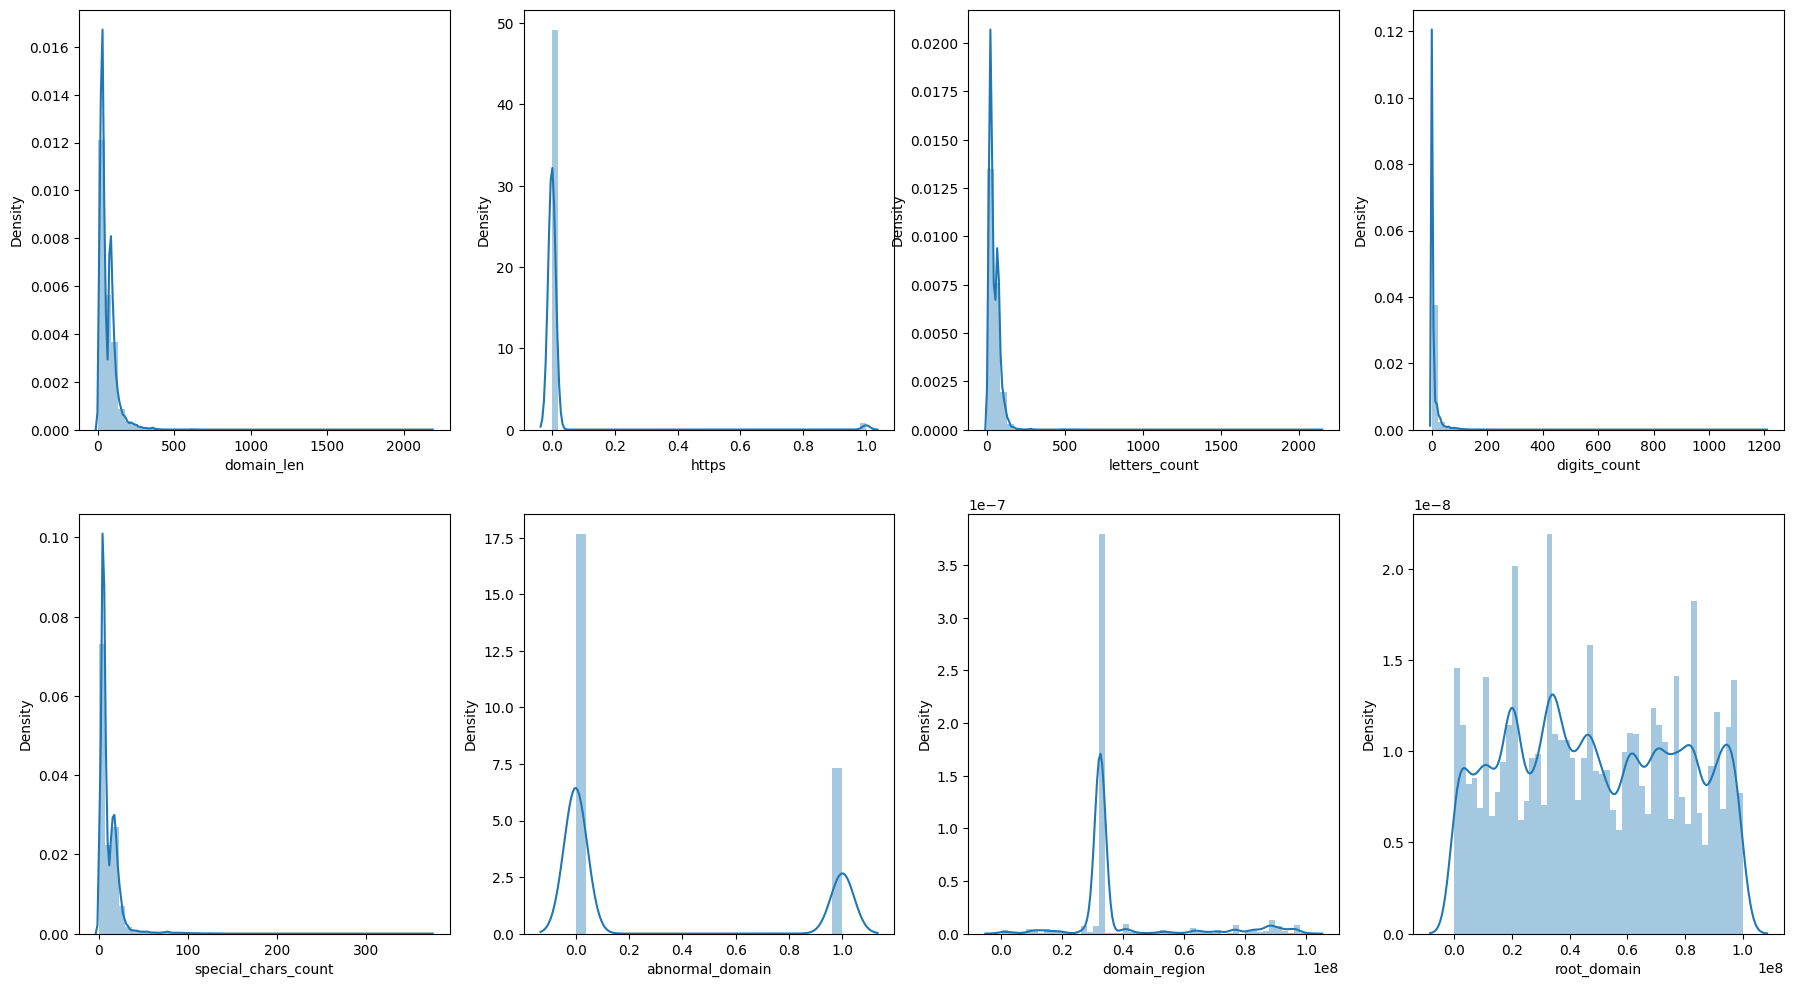

In [39]:
univariate_analysis(df,features)

- skewed distribtuion (expotional one): domain_len, letters_count, digits_count, special_chars_count 
- normal distribution: https, domain_region
- uniform distribution: root_domain
- Others: https/ abnormal_domain

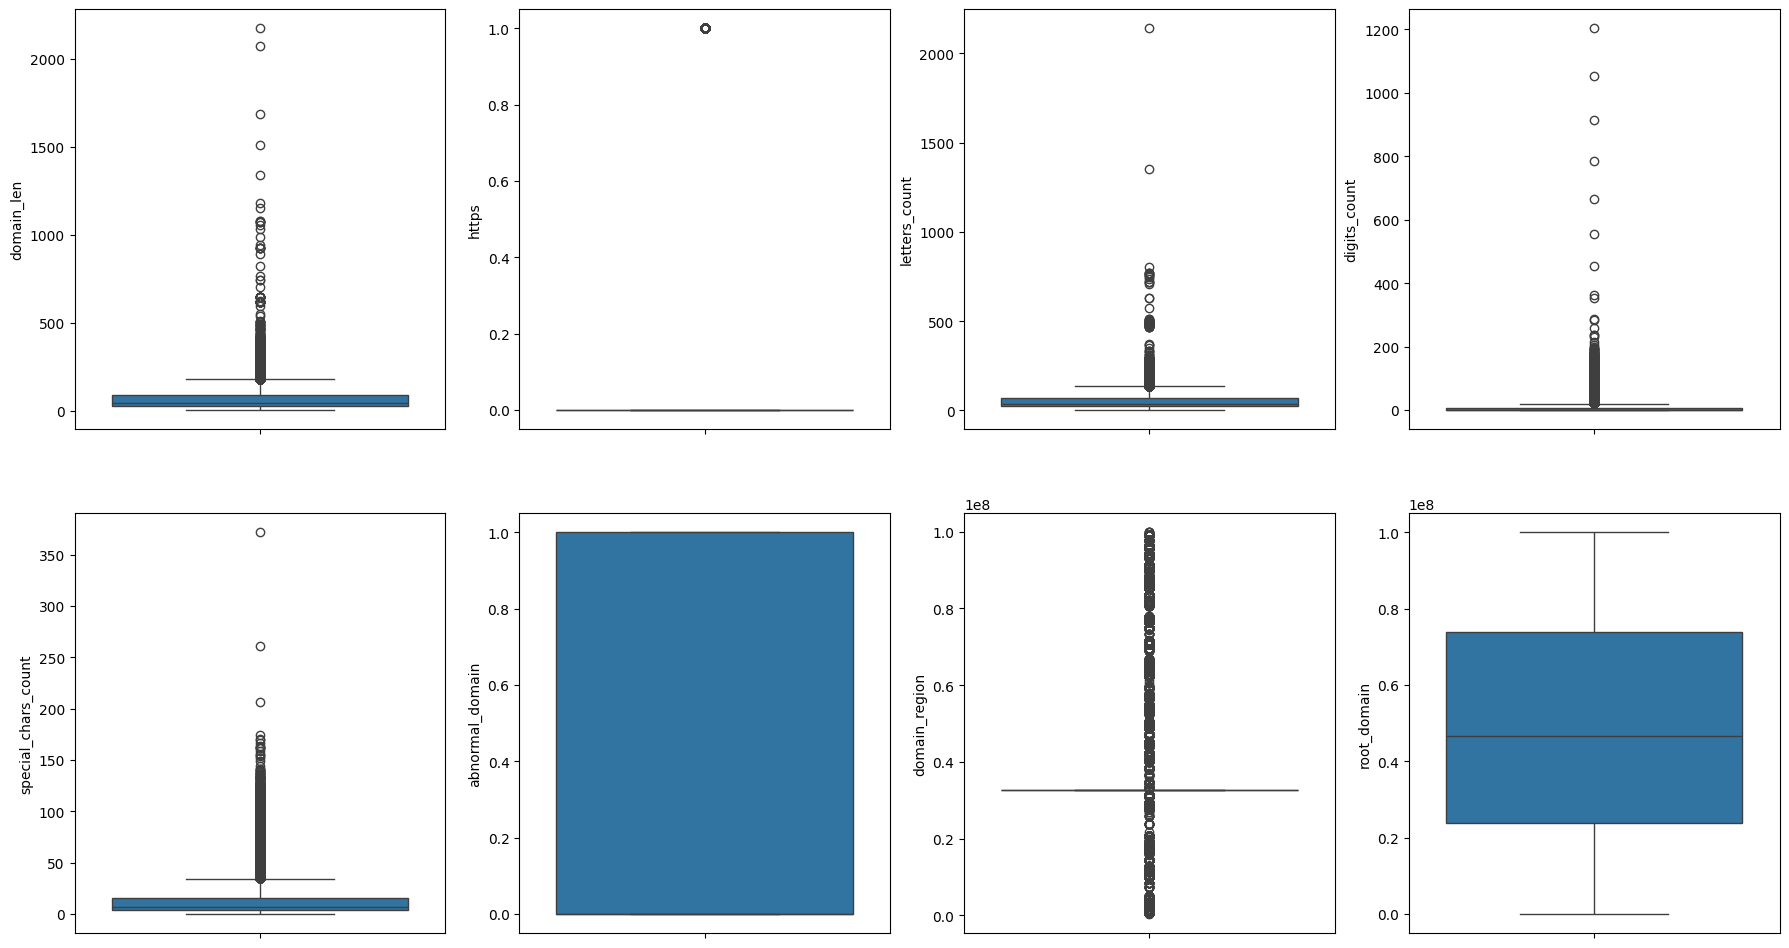

In [105]:
univariate_boxplot_analysis(df,features)

domain_len, letters_count, digits_count, special_chars_count, domain_region have outliers

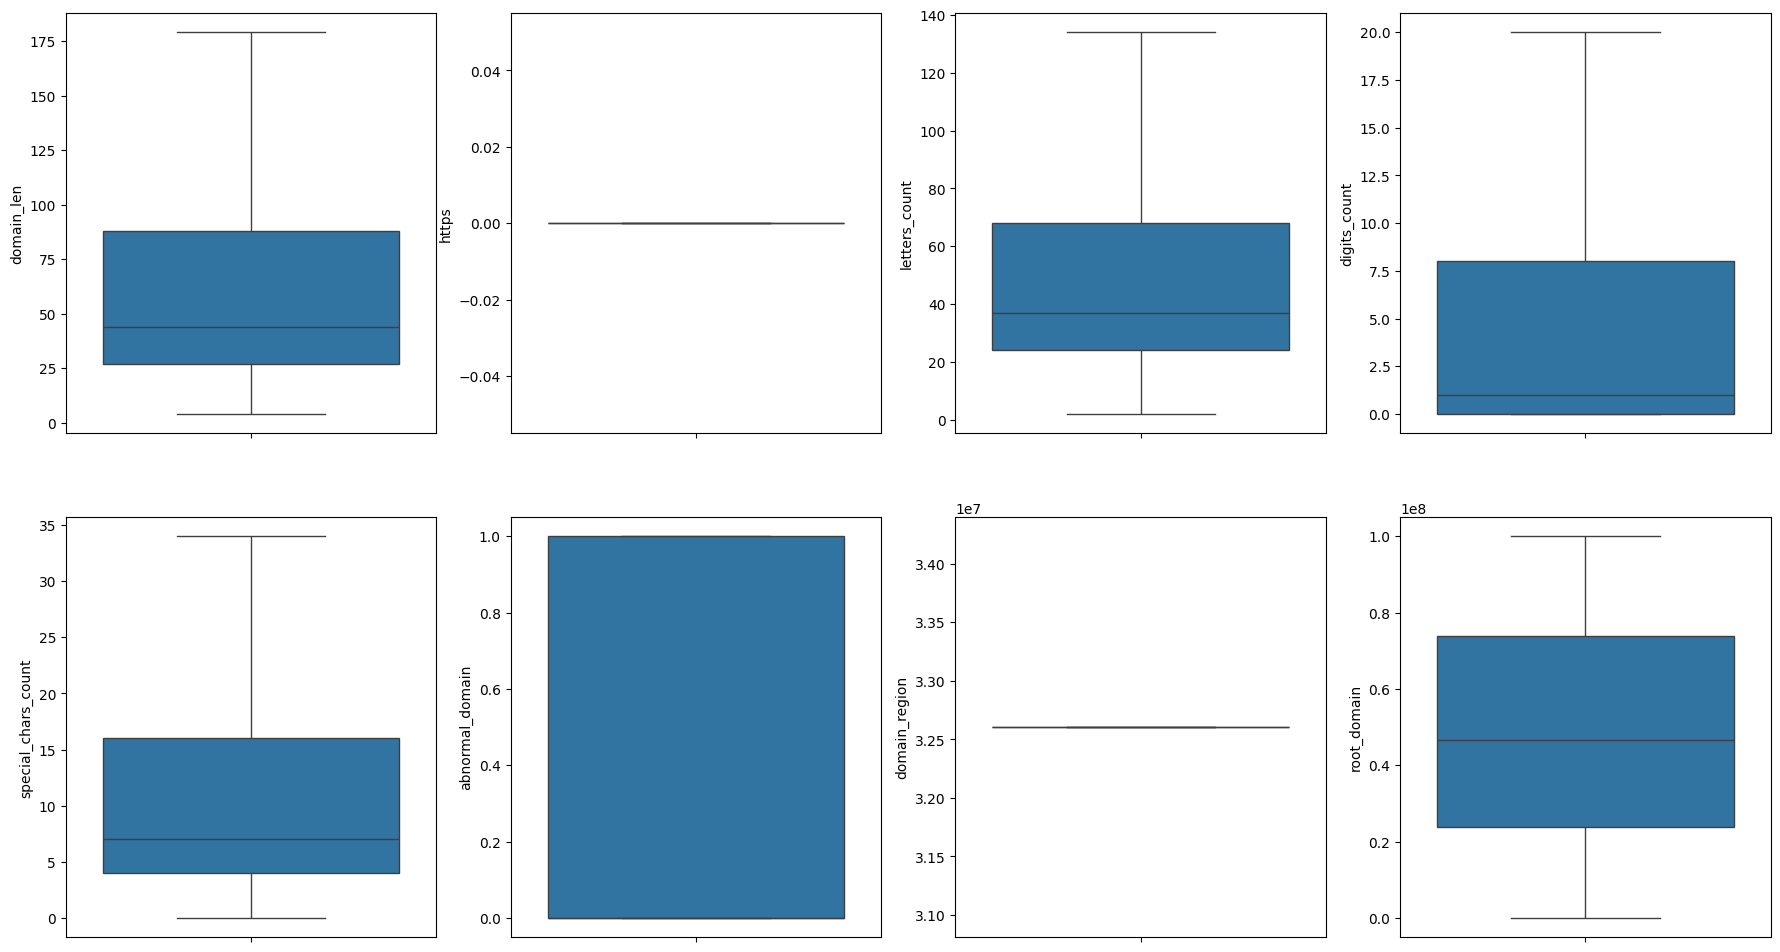

In [108]:
univariate_boxplot_analysis(df,features,outlier=False)

In [ ]:
# Multi variate Analysis 

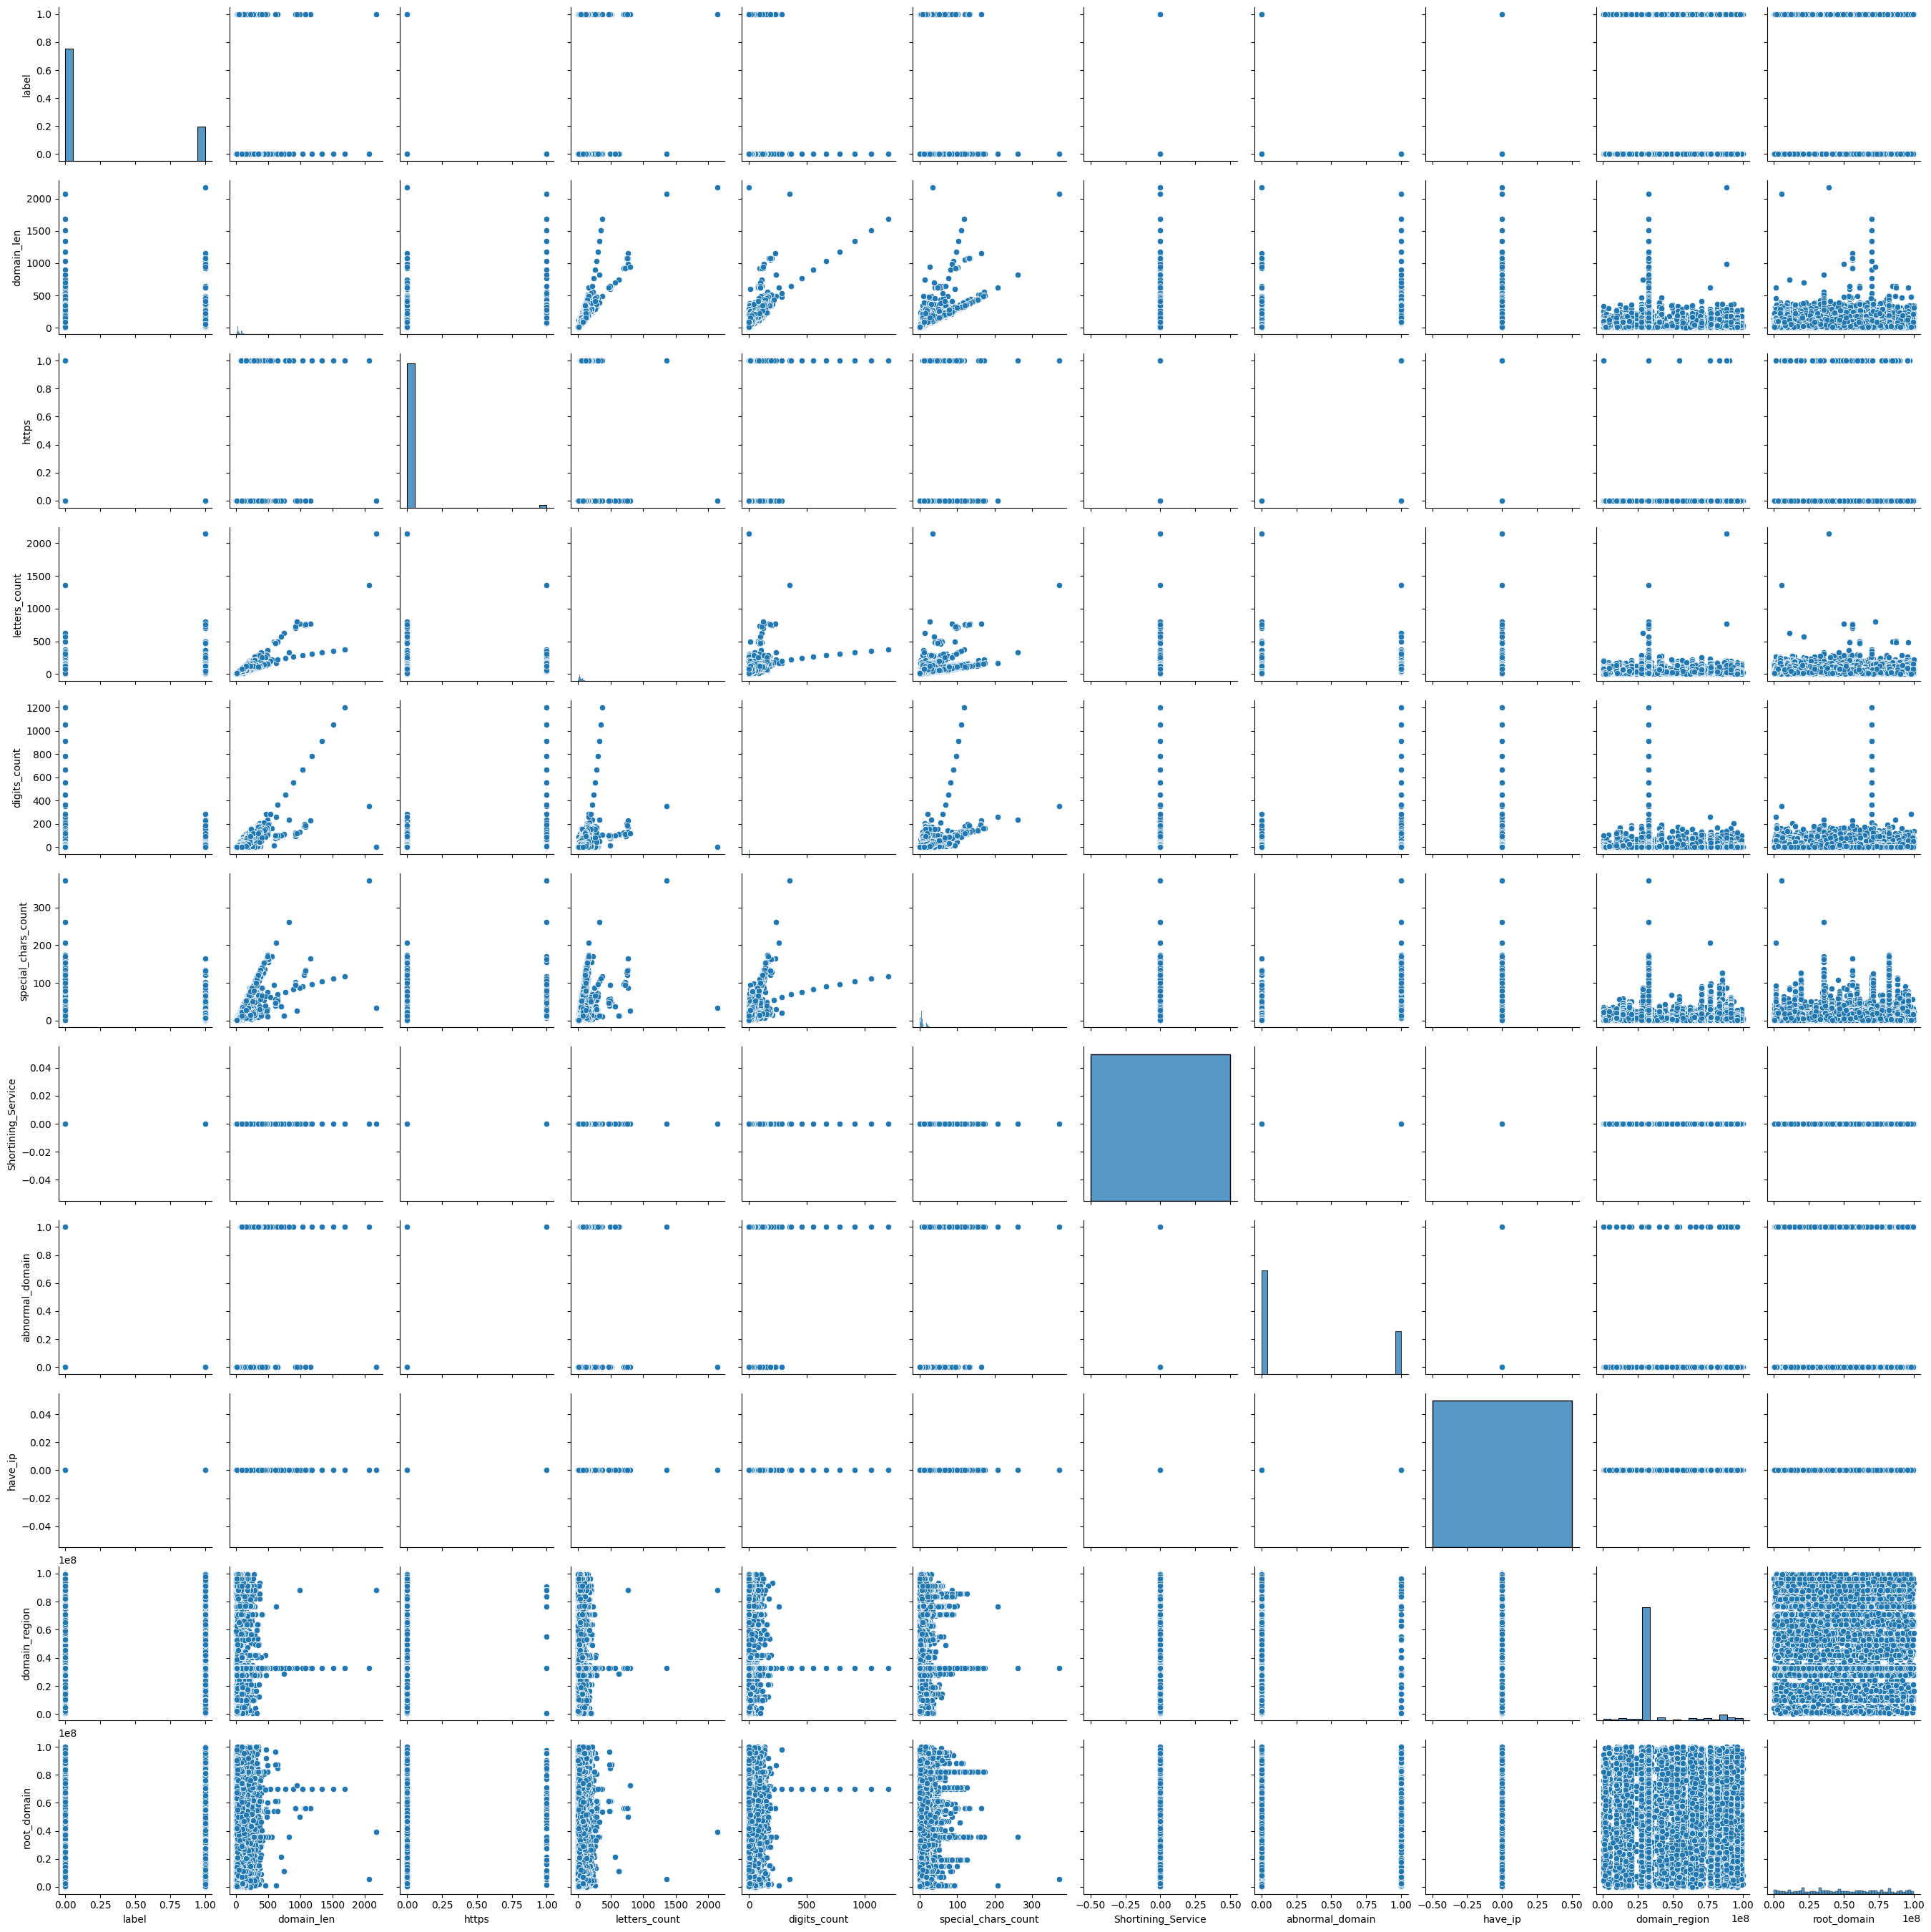

In [111]:
sns.pairplot(data)

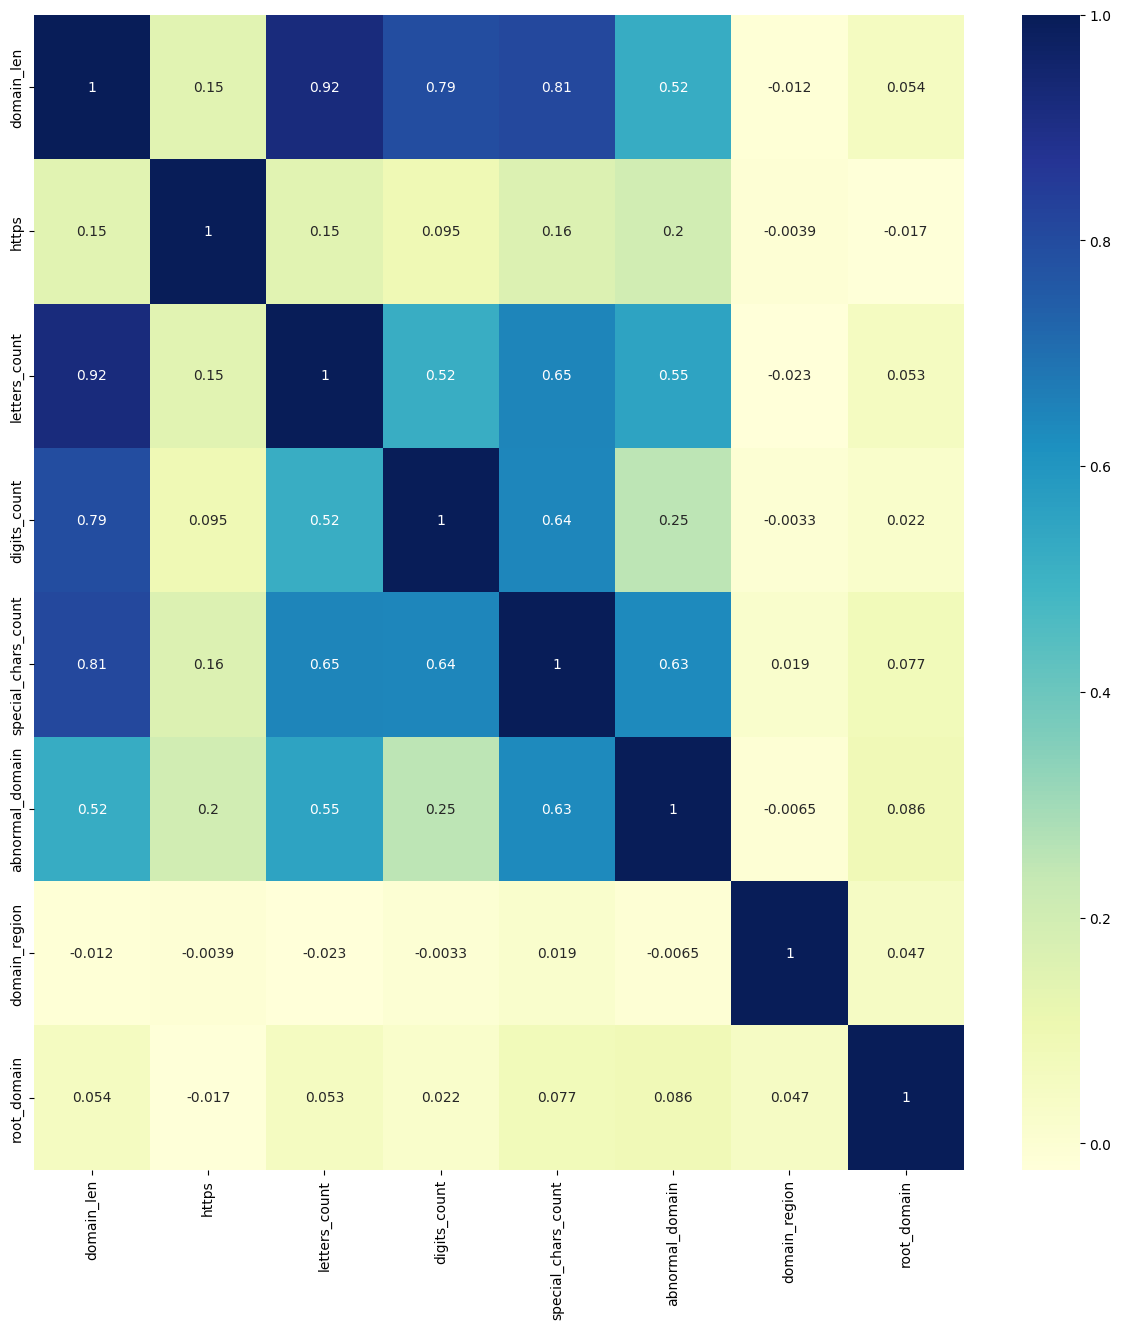

In [88]:
correlation_matrix(df)

Correlation Matrix:
- domain_len has high corelation with words characters (letters, digits and special one)
- domain_len and abnormal_domain have relative correlation
- The rest doesn't show much correlative relation

In detail:
- abnormal_domain has correlation with letters and special characters
--> If abnormal_domain is phishing, there is high propotional that urls having many characters are phishing, too

In [58]:
def outlier_removal(data,features):
    '''
    '''
    df_outlier = pd.DataFrame()
    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        outlier_range = Q1-1*IQR , Q3 + 1*IQR
        cond = (data[feature] < outlier_range[0]) | (data[feature] > outlier_range[1])
        outliers = data[cond]
        df_outlier = pd.concat([df_outlier, outliers])
    df_outlier.drop_duplicates(inplace=True)
    
    filtered_df = data.drop(df_outlier.index.to_list())
    filtered_df.reset_index(drop=True,inplace=True)
    return filtered_df,df_outlier

In [59]:
features

['domain_len',
 'https',
 'letters_count',
 'digits_count',
 'special_chars_count',
 'abnormal_domain',
 'domain_region',
 'root_domain']

# Data without outliers

In [66]:
data_filtered, data_outlier = outlier_removal(df,features)

In [83]:
data_outlier

,domain_len,https,letters_count,digits_count,special_chars_count,abnormal_domain,domain_region,root_domain
36,278,0,93,96,96,1,32604616,71141992
80,170,0,138,9,30,1,32604616,77161533
101,350,0,194,132,24,0,32604616,4037468
153,282,0,119,88,82,1,32604616,35538490
168,164,0,92,60,12,0,41946095,89495574
...,...,...,...,...,...,...,...,...
120960,33,0,31,0,6,0,81788327,8245892
120965,30,0,18,5,7,0,31475989,40424328
120977,9,0,8,0,1,0,96149071,98247991
120978,94,0,68,10,23,1,40557185,30237768


In [67]:
df.shape

(120990, 8)

In [68]:
data_filtered.shape

(84619, 8)

In [69]:
data_filtered.describe()

,domain_len,https,letters_count,digits_count,special_chars_count,abnormal_domain,domain_region,root_domain
count,84619.000,84619.000,84619.000,84619.000,84619.000,84619.000,84619.000,84619.000
mean,52.473,0.004,42.281,4.135,9.152,0.269,33962040.835,48371361.885
std,35.375,0.059,25.616,8.444,7.778,0.444,9008556.423,28767743.969
min,6.000,0.000,2.000,0.000,0.000,0.000,582857.000,3368.000
25%,27.000,0.000,23.000,0.000,4.000,0.000,32604616.000,22364912.000
50%,39.000,0.000,34.000,1.000,6.000,0.000,32604616.000,46406467.000
75%,80.000,0.000,63.000,6.000,14.000,1.000,32604616.000,73088408.000
max,417.000,1.000,289.000,172.000,134.000,1.000,99146493.000,99995991.000


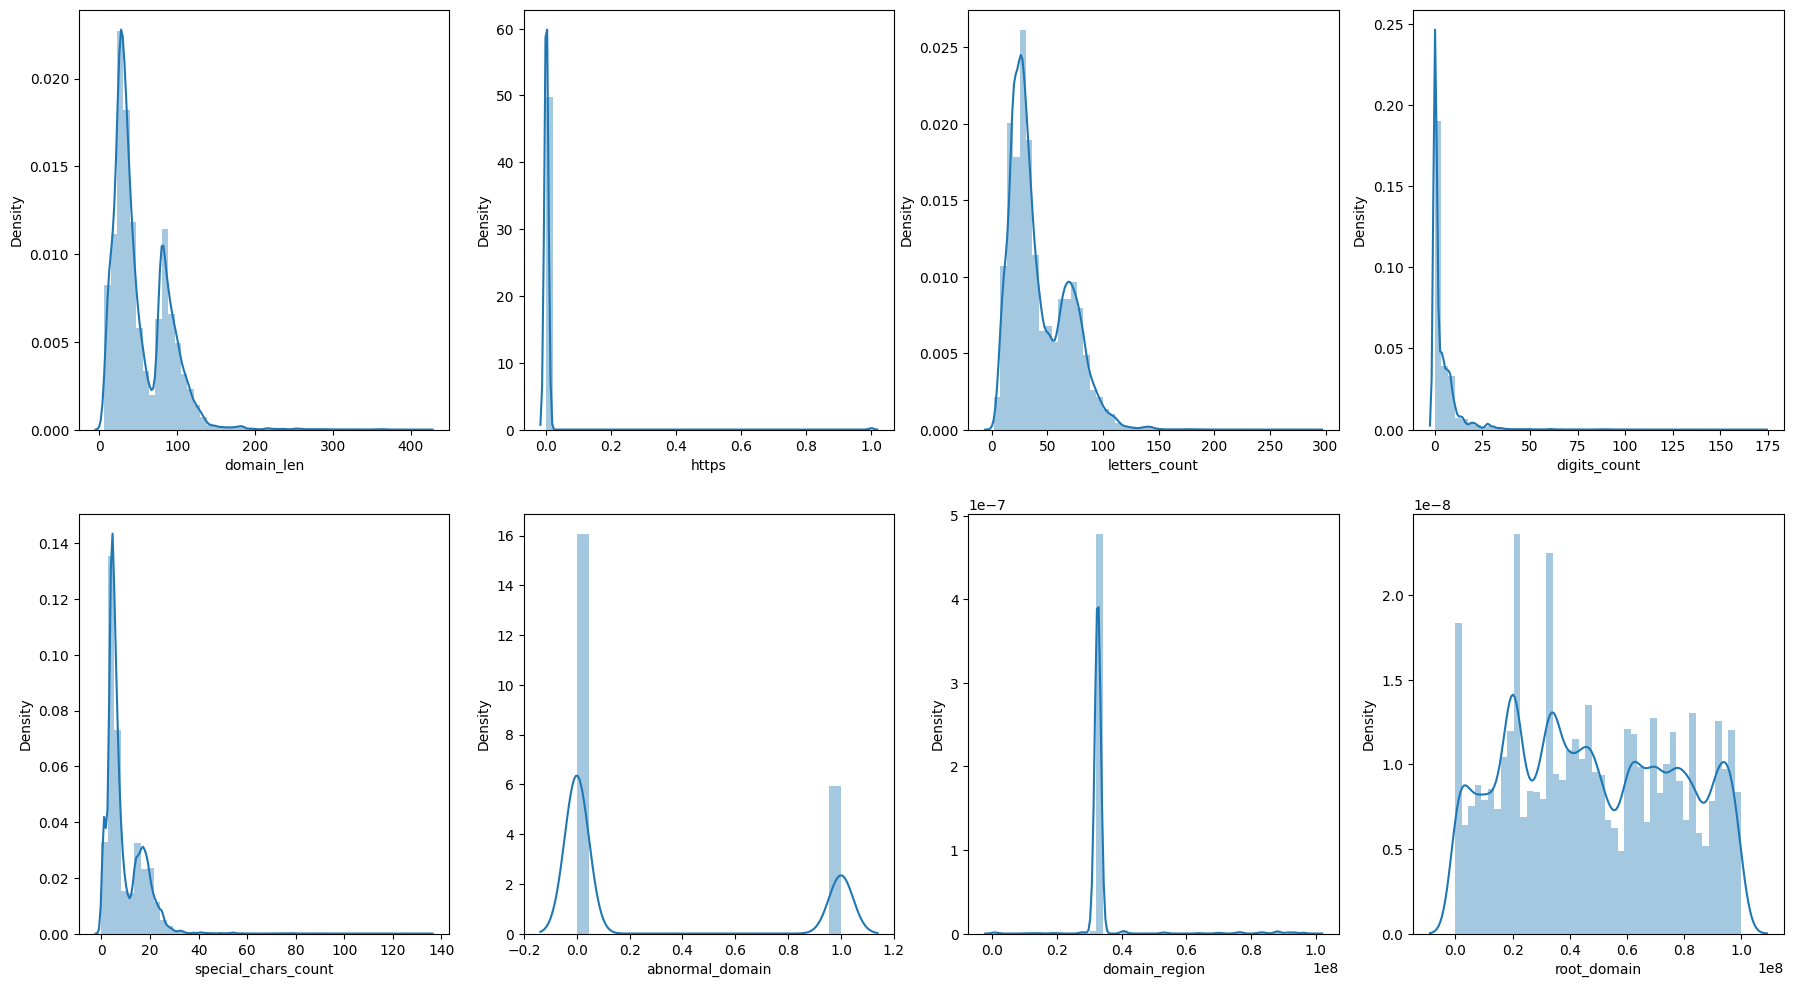

In [70]:
univariate_analysis(data_filtered,features)

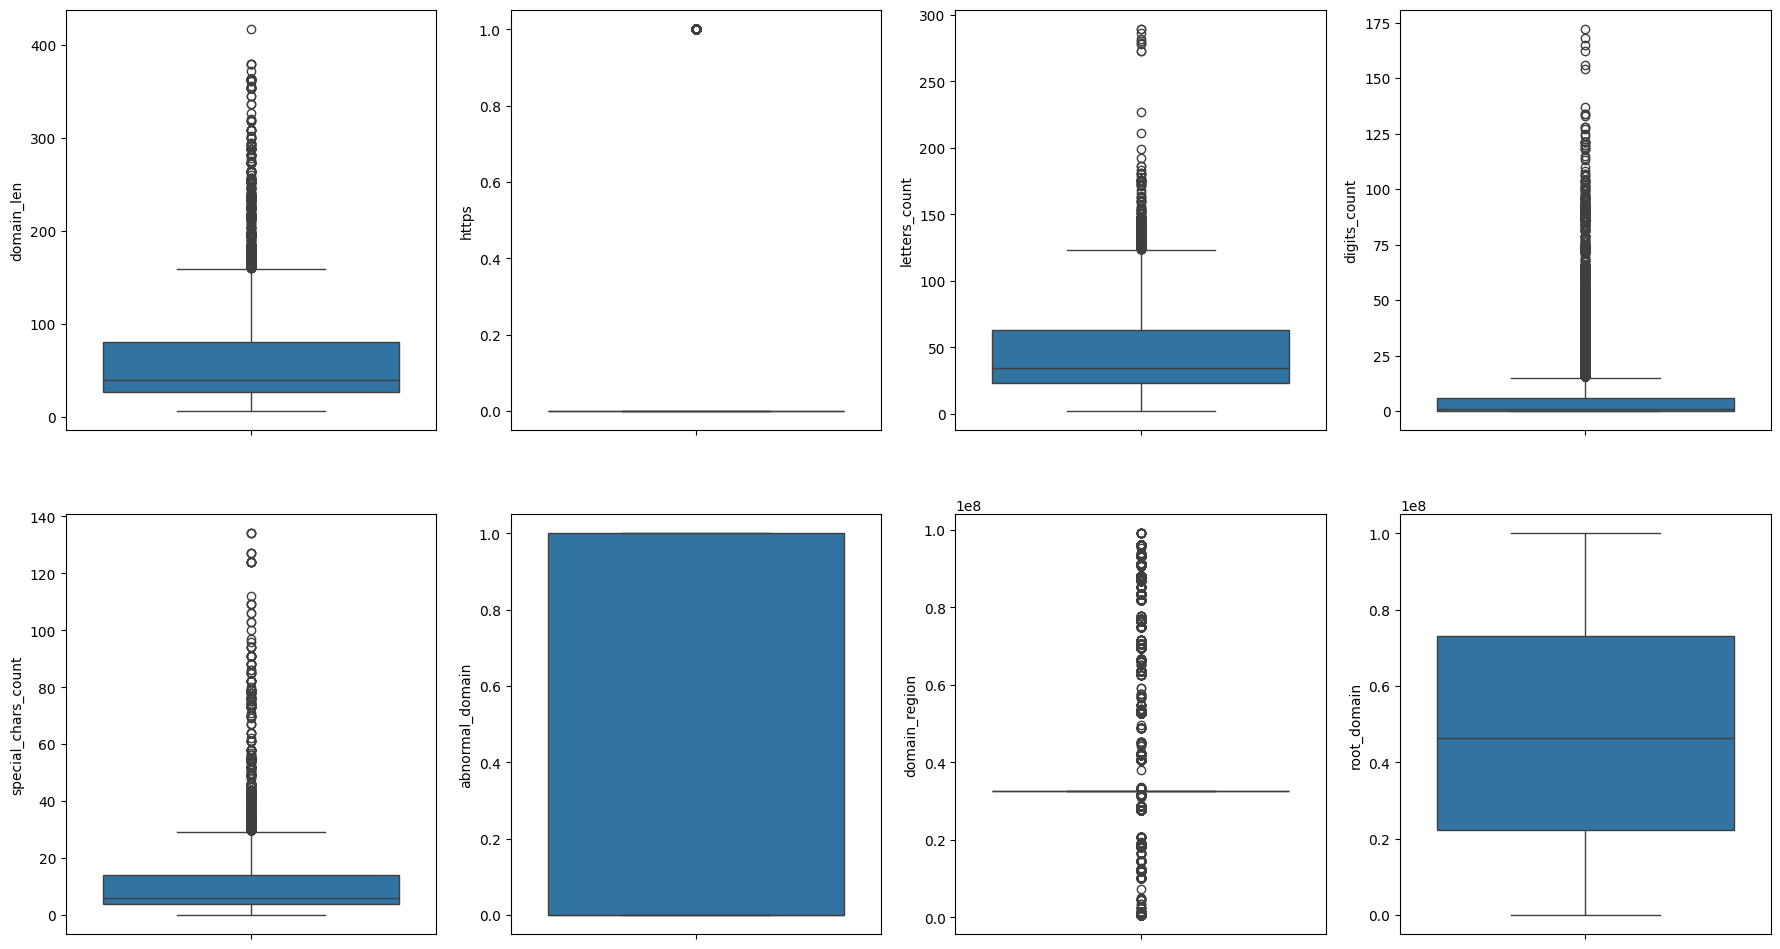

In [71]:
univariate_boxplot_analysis(data_filtered,features)

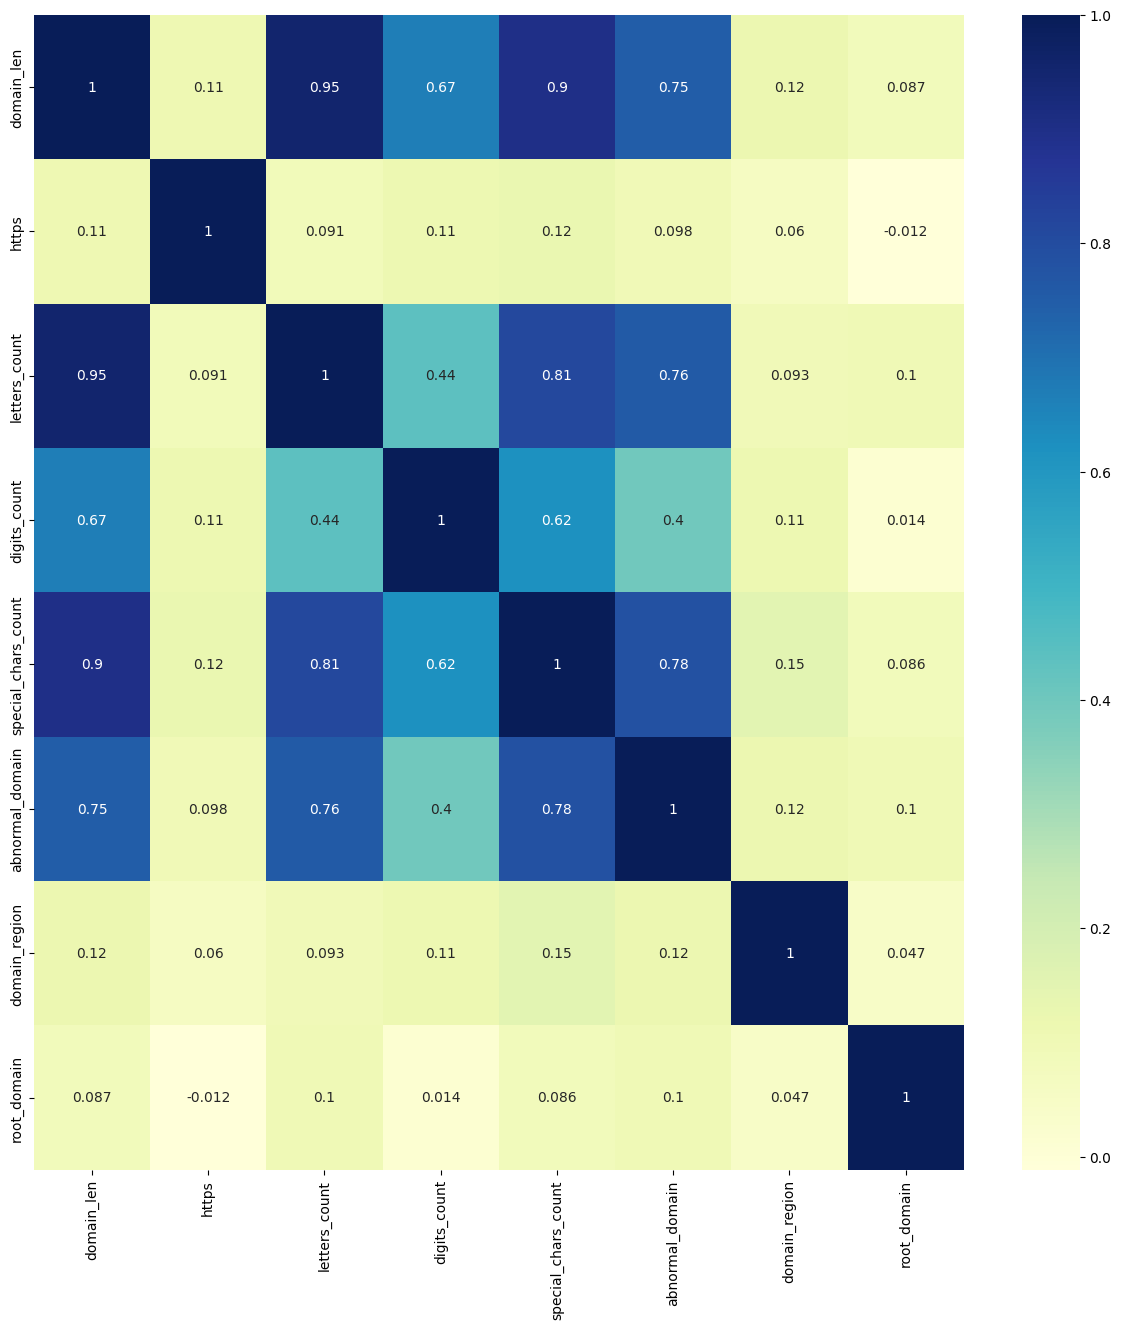

In [81]:
correlation_matrix(data_filtered)

Correlation value Increasing beween abnormal domain with domain leng 
The rest is still the same 
The outliers here are important because some of them may be a phising domain, which can be harmful. 

 ---> Therefore, keeping these outliers are more important than removing them.

# Data Spliting

In [87]:
trainX, testX, trainY, testY = train_test_split(df, data.label,random_state=40, test_size = 0.25)

# Model Development

The objective of this issue is classification between phishing and legitimate urls. Therefore, all 5 proposed methods below are suitable for classification problem in the purpose of comparision with the stacking method below.
- Logistic Regression 
- Multinominal Naive Bayes 
- Random Forest 
- Ada Boost (bagging method)
- Extreme Gradient Boosting (XG Boost - boosting method)



In [89]:
# Creating holders to store the model performance (test set) results
ML_Model = []
accuracy = []
f1_score = []
recall = []
precision = []
specificity = []

#function to call for storing the results
def store_results(model, a,b,c,d,e):
  ML_Model.append(model)
  accuracy.append(round(a, 3))
  f1_score.append(round(b, 3))
  recall.append(round(c, 3))
  precision.append(round(d, 3))
  specificity.append(round(e, 3))

## Logistic Regression

In [245]:
lr = LogisticRegression()# before fitting
lr, lr_score = model_fitting(lr, trainX, trainY, testX, testY)
lr_score

0.7648439566252314

Training Accuracy : 0.766
Testing Accuracy : 0.765

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.76      1.00      0.87     23135
           1       0.00      0.00      0.00      7113

    accuracy                           0.76     30248
   macro avg       0.38      0.50      0.43     30248
weighted avg       0.58      0.76      0.66     30248


CONFUSION MATRIX


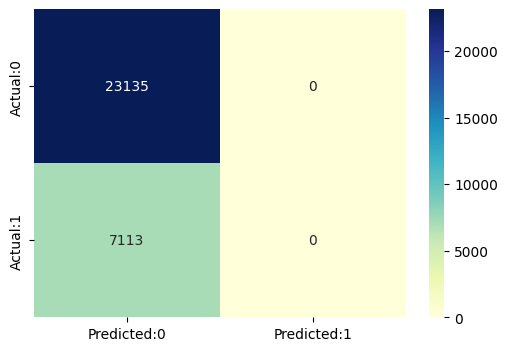

In [246]:
model_evalution_report(lr, trainX, trainY, testX, testY)

In [249]:
# Saving model
model = 'Logistic Regression'
title = model + '.sav'
save_model(lr,save_path,title)

In [250]:
#storing the results. The below mentioned order of parameter passing is important.
model = 'Logistic Regression'
title = model + '.sav'
loaded_model = load_model(save_path,title)
acc_test,f1_score_test,recall_score_test,precision_score_test,specificity_score_test = model_evaluation_score(loaded_model, trainX, trainY, testX, testY)
store_results(model,acc_test,f1_score_test,recall_score_test,precision_score_test,specificity_score_test)

# MultinomialNB

In [251]:
# create mnb object
mnb = MultinomialNB()
mnb, mnb_score = model_fitting(mnb, trainX, trainY, testX, testY)
mnb_score

0.5258860089923301

Training Accuracy : 0.526
Testing Accuracy : 0.526

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.79      0.52      0.63     23135
           1       0.26      0.56      0.36      7113

    accuracy                           0.53     30248
   macro avg       0.53      0.54      0.49     30248
weighted avg       0.67      0.53      0.56     30248


CONFUSION MATRIX


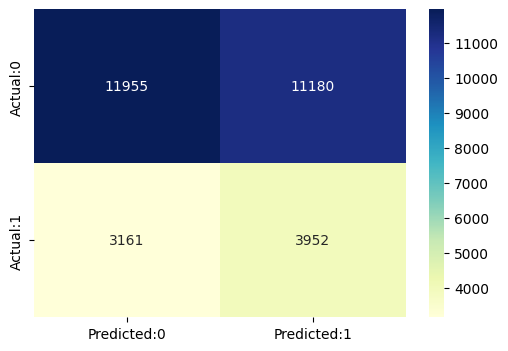

In [252]:
model_evalution_report(mnb, trainX, trainY, testX, testY)

In [253]:
#storing the results.
model = 'Multinomial Naive Bayes'
acc_test,f1_score_test,recall_score_test,precision_score_test,specificity_score_test = model_evaluation_score(mnb, trainX, trainY, testX, testY)
store_results(model,acc_test,f1_score_test,recall_score_test,precision_score_test,specificity_score_test)

# Random Forest

In [254]:
rf = RandomForestClassifier(random_state=0)
rf, rf_score = model_fitting(rf, trainX, trainY, testX, testY)
# Saving model
model = 'Random Forest'
title = model + '.sav'
save_model(rf,save_path,title)
rf_score

0.9271026183549326

Training Accuracy : 1.000
Testing Accuracy : 0.927

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     23135
           1       0.86      0.83      0.84      7113

    accuracy                           0.93     30248
   macro avg       0.90      0.89      0.90     30248
weighted avg       0.93      0.93      0.93     30248


CONFUSION MATRIX


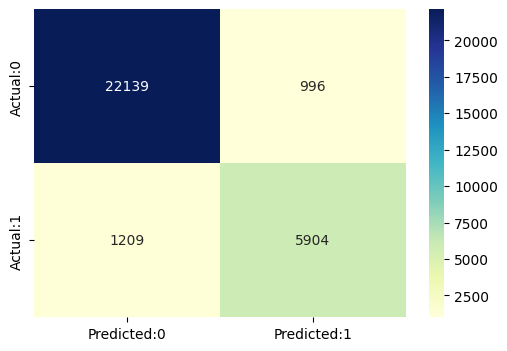

In [97]:
model_evalution_report(rf, trainX, trainY, testX, testY)

In [104]:
importances = loaded_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in loaded_model.estimators_], axis=0)

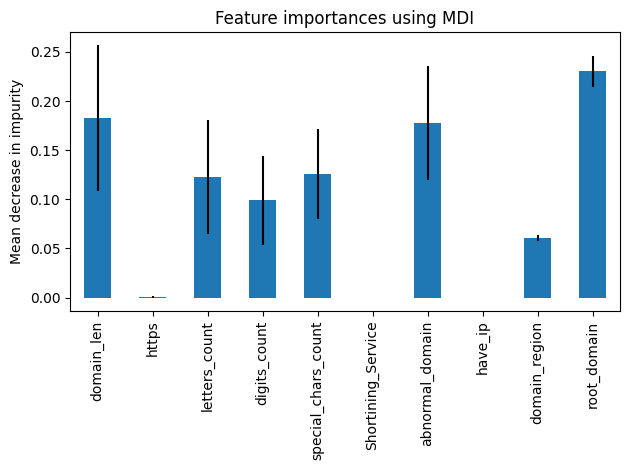

In [105]:
forest_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [93]:
# Loading model - Store Result
model = 'Random Forest'
title = model + '.sav'
loaded_model = load_model(save_path,title)
acc_test,f1_score_test,recall_score_test,precision_score_test,specificity_score_test = model_evaluation_score(loaded_model, trainX, trainY, testX, testY)
store_results(model,acc_test,f1_score_test,recall_score_test,precision_score_test,specificity_score_test)

# Ada Boost

In [257]:
ABC = AdaBoostClassifier(random_state=0)
ABC, ABC_score = model_fitting(ABC, trainX, trainY, testX, testY)
# Saving model
model = 'Ada Boost'
title = model + '.sav'
save_model(ABC,save_path,title)
ABC_score

0.8958939434012166

Training Accuracy : 0.896
Testing Accuracy : 0.896

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     23135
           1       0.85      0.67      0.75      7113

    accuracy                           0.90     30248
   macro avg       0.88      0.82      0.84     30248
weighted avg       0.89      0.90      0.89     30248


CONFUSION MATRIX


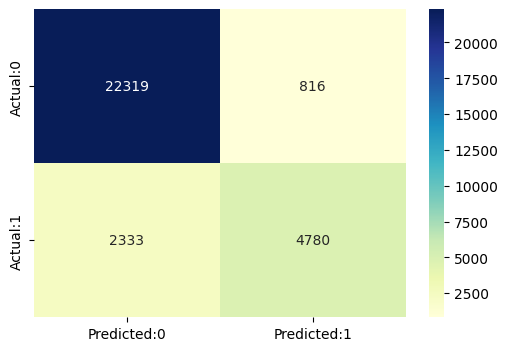

In [258]:
model_evalution_report(ABC, trainX, trainY, testX, testY)

In [259]:
# Loading model
model = 'Ada Boost'
title = model + '.sav'
loaded_model = load_model(save_path,title)
acc_test,f1_score_test,recall_score_test,precision_score_test,specificity_score_test = model_evaluation_score(loaded_model, trainX, trainY, testX, testY)
store_results(model,acc_test,f1_score_test,recall_score_test,precision_score_test,specificity_score_test)

# XG Boost

In [260]:
XGC = xgb.XGBClassifier()
XGC, XGC_score = model_fitting(XGC, trainX, trainY, testX, testY)
XGC_score

0.9367230891298598

Training Accuracy : 0.950
Testing Accuracy : 0.937

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     23135
           1       0.89      0.83      0.86      7113

    accuracy                           0.94     30248
   macro avg       0.92      0.90      0.91     30248
weighted avg       0.94      0.94      0.94     30248


CONFUSION MATRIX


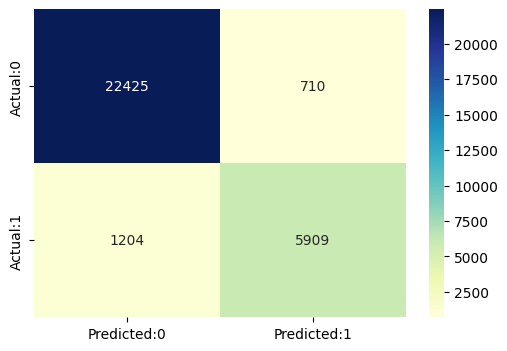

In [261]:
model_evalution_report(XGC, trainX, trainY, testX, testY)

In [263]:
# Saving model
model = 'XG Boost'
title = model + '.sav'
save_model(XGC,save_path,title)

In [264]:
# Loading model
model = 'XG Boost'
title = model + '.sav'
loaded_model = load_model(save_path,title)
acc_test,f1_score_test,recall_score_test,precision_score_test,specificity_score_test = model_evaluation_score(loaded_model, trainX, trainY, testX, testY)
store_results(model,acc_test,f1_score_test,recall_score_test,precision_score_test,specificity_score_test)

# Propsed Stacking Method

Ref:

A.Newaz et al, Sophisticated Framework for the Accurate Detection of Phising Websites, 2024 
Sophisticated Framework for the Accurate Detection of Phising Websites (13-03-2024)

The proposed method using base estimators: 
- Random Forest 
- Extreme Gradient Boosting (boosting method)
- K-Nearest Neighbors
- AdaBoost (bagging method)
- Multinomial Naive Bayes

And the final estimator is Multi-layer Perceptron

The parameters of the base learnners of the stacked model are selected as default (as other words, they're not optimized)
Parameter optimization can improve the accuracy of the classifiers. However, it is an extremely time-cosuming process that often leads to a loss of generalization. Therefore, parameter tuning was avoided and the default parameters of the scikit-learn library were used to train the classifiers

RFECV algorithm is utilized to identify the most suitable subset of features of each classifier, so RFECV algorithm was particularly effective in reducing the number of features in thoses cases

In [ ]:
estimators = [
     ('rfc', RandomForestClassifier(random_state=0)),
      ('xgc', xgb.XGBClassifier()),
      ('lr', LogisticRegression()),
      ('knn', KNeighborsClassifier()),
      ('ada', AdaBoostClassifier(random_state=0)),
      ('mnb', MultinomialNB())
 ]
final_estimator = MLPClassifier(random_state=0)
clf = StackingClassifier(
     estimators=estimators, 
    final_estimator = final_estimator,
)
stacking_model = RFECV(clf, min_features_to_select = 50, step = 1 , cv =10)
stacking_model, stacking_model_score = model_fitting(stacking_model, trainX, trainY, testX, testY)

# Saving model
model = 'Stacking Model'
title = model + '.sav'
save_model(stacking_model,save_path,title)

stacking_model_score


In [90]:
# Loading model
model = 'Stacking Model'
title = model + '.sav'
loaded_model = load_model(save_path,title)
acc_test,f1_score_test,recall_score_test,precision_score_test,specificity_score_test = model_evaluation_score(loaded_model, trainX, trainY, testX, testY)
store_results(model,acc_test,f1_score_test,recall_score_test,precision_score_test,specificity_score_test)

# Model Evalutation
5 different performance measures - accuracy, f1_score, Recall, Precision and Specificity.

Among them, the Recall, Specificity are the most importance measures because ,in the field of cybersecurity, when users misclick on unknown urls the consequences of phishing are much more serious than a legitimate one. 
Therefore, it is necessary, in this case, to lower the False Negative --> high Recall 
and high True Negative --> high Specificity 

In [267]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'f1_score' : f1_score,
                        'Recall'   : recall,
                        'Precision': precision,
                       'Specificity': specificity,                         
                      })

In [268]:
#Sorting the datafram on accuracy
sorted_result=result.sort_values(by=['Recall','Specificity'],ascending=False).reset_index(drop=True)
sorted_result

,ML Model,Accuracy,f1_score,Recall,Precision,Specificity
0,Logistic Regression,0.765,0.000,1.000,0.765,0.000
1,XG Boost,0.937,0.861,0.969,0.949,0.831
2,Ada Boost,0.896,0.752,0.965,0.905,0.672
3,Stacking Model,0.950,0.895,0.964,0.970,0.904
4,Random Forest,0.927,0.843,0.957,0.948,0.830
5,Multinomial Naive Bayes,0.526,0.355,0.517,0.791,0.556


Based on the performance measures, although Logistic Regression (LR) has an absolute Recall but Specificity is the lowest 0. Meanwhile, the second method in the Recall measure (XG Boost) has the second highest Recall as well as high in Specificity. In the contrary, its f1-score is not good.
Regarding Ada Boost, its specificity is quite low, which is compared to the other. Therefore, the Stacking Model is the best among these machine learning methods, it has high Recall and Specificity at 0.964 and 0.904, respectively. Though it's not the highest, its f1-score is the greatest, which balances the generalization and optimization.  In addition, its accuracy is the highest at 0.95.

In conclusion, up to now, the proposed stacking method is the best for this classification problem.

In [72]:
# Feature Importance

# Generalization

In [302]:
def data_text_preprocessing(data):
    '''
    Text Processing before being fed into model 
    ----------
    Attributes:
    data: input data
        list,pd.series
    return: preprocessed data
        pd.DataFrame
    ----------
    Example:
    predict_good = ['youtube.com/',
                'youtube.com/watch?v=qI0TQJI3vdU',
                'retailhellunderground.com/',
                'restorevisioncenters.com/html/technology.html']
    processed_predict_good = data_text_preprocessing(predict_good)
    '''
    data = pd.DataFrame(data,columns=['domain'])
    data['domain_len'] = data['domain'].apply(lambda x: get_url_length(str(x)))
    data['pri_domain'] = data['domain'].apply(lambda i: extract_pri_domain(i))    
    data['https'] = data['domain'].apply(lambda i: httpSecure(i))
    data['letters_count']        = data['domain'].apply(lambda x: count_letters(x))
    data['digits_count']         = data['domain'].apply(lambda x: count_digits(x))
    data['special_chars_count']  = data['domain'].apply(lambda x: count_special_chars(x))
    data['Shortining_Service']  = data['domain'].apply(lambda x: has_shortening_service(x))
    data['abnormal_domain']  = data['domain'].apply(lambda x: abnormal_url(x))
    data['have_ip']  = data['domain'].apply(lambda x: have_ip_address(x))
    data['domain_region'] = data['pri_domain'].apply(lambda x: get_url_region(str(x)))
    data['root_domain'] = data['pri_domain'].apply(lambda x: extract_root_domain(str(x)))
    data['root_domain'] = data['root_domain'].apply(hash_encode)
    data['domain_region'] = data['domain_region'].apply(hash_encode)     
    data = data.drop(columns=['domain','pri_domain'])
    return data

In [297]:
model = 'Stacking Model'
title = model + '.sav'
loaded_model = load_model(save_path,title)
loaded_model

In [306]:
predict_good = ['youtube.com/',
                'youtube.com/watch?v=qI0TQJI3vdU',
                'retailhellunderground.com/',
                'restorevisioncenters.com/html/technology.html']
processed_predict_good = data_text_preprocessing(predict_good)
result = loaded_model.predict(processed_predict_good)

In [307]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php',
               'fazan-pacir.rs/temp/libraries/ipad',
               'tubemoviez.exe',
               'svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
processed_predict_bad = data_text_preprocessing(predict_bad)
result2 = loaded_model.predict(processed_predict_bad)

In [308]:
print(result)
print("*"*30)
print(result2)

[0. 0. 1. 1.]
******************************
[1. 1. 0. 1.]


# Perspective

The proposition of an approach for maintenance and model updating in the future:
- Checking the data quality (is it the same distribution as the data fed into training model) after data 
- Making sure that the new data is followed the old data distribution by using statiscal Test (the Chi-square test or machine learning method,...) to make sure that the similarity between new and old data. In other way, machine learning method will be applied fo r this issue by training the model on the old data and evaluate its performance on the new data. If model performs well on the new data, it suggests that the distribution are similar.Feeding new data by using the data preprocessing in the notebooks.
    - Get url lengh 
    -Extract primary domain
    - Check whether domains having https (secure)
    - Count the number of digit characters
    - Count the number of letter characters
    - Count special characters
    - Check whether domains containing a shortening service
    - Check wether having abnormal domain
    - Check wether having IP address
    - Extract regional domain
    - Extract root domain
- Model evalutation (performance) (espically recall,specificity and accuracy) or using other techniques such as feature importance analysis, confusion matices , confidence intervals 
- If the model performance's lower than particular thresholds, model will be modified so as to update to newest data
- To do so,  model monitoring is required to identy and resolve any issues or anomolies that may arise during their behavior, performance and impact. To do this effectively, some useful tools as logging, dashboarding and alerting on a  periodically basis


In addition, the proposed method is still having some things need to be improved:
- Imbalancing data with affecting on the results
- The Specificity should be as high as possible for the next work, the target is should be larger than 90%
- Need more research on the feature engineering in the cyber security field
- The last part, generalization, shows that there are still serious cases (can be recognized by human but the algorithm fails to detect it) which is needed to be handled(Ex "www.tubemoviez.exe" )
- ...